# 1. Imports and preparations

In [1]:
import pandas as pd
from prettytable import PrettyTable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def rmse(y1,y2):
    return(np.sqrt(mean_squared_error(y1,y2)))
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingRegressor,ExtraTreesRegressor,GradientBoostingRegressor, RandomForestRegressor
from catboost imprt CatBoost, CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
from copy import deepcopy
import optuna

In [44]:
from functools import partial


In [47]:
import gc

In [5]:
train_data = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')

In [6]:
train_data.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [7]:
train_data.drop(columns=["id"],inplace=True)
test_data.drop(columns=["id"],inplace=True)
print("Train Data Size: ",train_data.shape)
print("Test Data Size: ",test_data.shape)

Train Data Size:  (74051, 9)
Test Data Size:  (49368, 8)


# 2. Understanding the data

In [8]:
table = PrettyTable()

table.field_names = ['Column Name', 'Data Type', 'Train Missing %', 'Test Missing %']
for column in train_data.columns:
    data_type = str(train_data[column].dtype)
    missing_percent_train= 100-train_data[column].count()/train_data.shape[0]*100
    missing_percent_test = 100-test_data[column].count()/test_data.shape[0]*100 if column != 'Age' else 100
    table.add_row([column, data_type, missing_percent_train,missing_percent_test])
print(table)

+----------------+-----------+-----------------+----------------+
|  Column Name   | Data Type | Train Missing % | Test Missing % |
+----------------+-----------+-----------------+----------------+
|      Sex       |   object  |       0.0       |      0.0       |
|     Length     |  float64  |       0.0       |      0.0       |
|    Diameter    |  float64  |       0.0       |      0.0       |
|     Height     |  float64  |       0.0       |      0.0       |
|     Weight     |  float64  |       0.0       |      0.0       |
| Shucked Weight |  float64  |       0.0       |      0.0       |
| Viscera Weight |  float64  |       0.0       |      0.0       |
|  Shell Weight  |  float64  |       0.0       |      0.0       |
|      Age       |   int64   |       0.0       |      100       |
+----------------+-----------+-----------------+----------------+


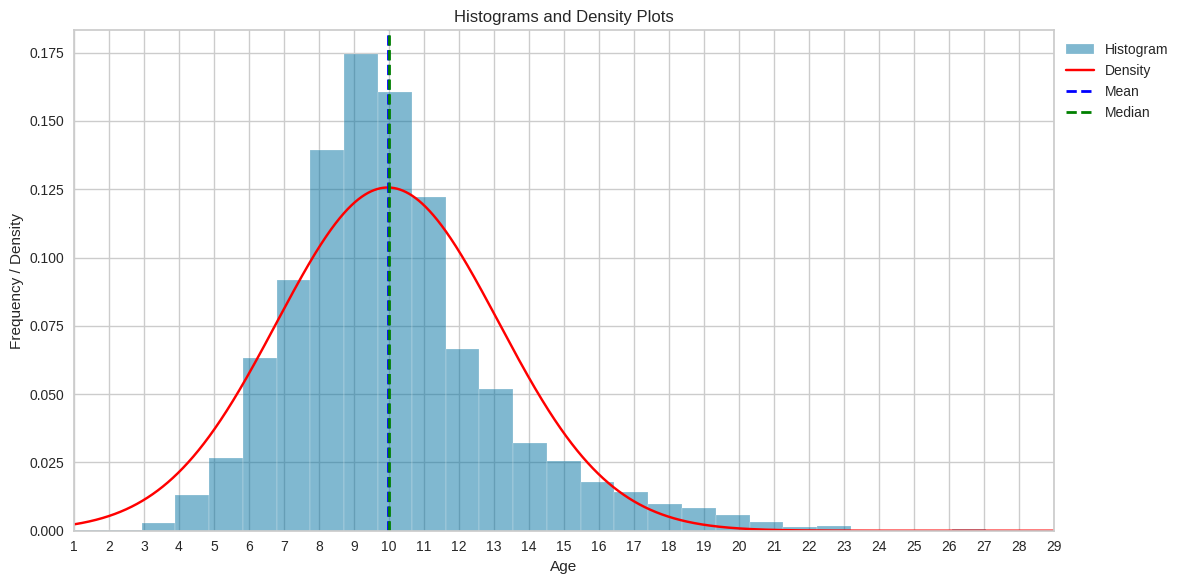

In [9]:
x_data = train_data.Age

x_mean = x_data.mean()
x_median = x_data.median()
x_min = x_data.min()
x_max = x_data.max()


fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(x_data, bins=x_max-x_min+1, density=True, alpha=0.5, label='Histogram')

x_values = np.linspace(x_min, x_max, len(x_data))
density_values = (1 / (np.sqrt(2 * np.pi) * np.std(x_data))) * np.exp(-0.5 * ((x_values - x_mean) / np.std(x_data))**2)
ax.plot(x_values, density_values, color='red', label='Density')

ax.axvline(x_mean, color='blue', linestyle='dashed', linewidth=2, label='Mean')
ax.axvline(x_median, color='green', linestyle='dashed', linewidth=2, label='Median')

ax.set_xlabel('Age')
ax.set_ylabel('Frequency / Density')
ax.set_title('Histograms and Density Plots')

# Manually set x-axis limits to ensure full visibility
ax.set_xlim([x_min, x_max])
ax.set_xticks(np.arange(x_min, x_max+1, 1.0))
ax.legend(bbox_to_anchor=(1,1),fancybox=False,shadow=False, loc='upper left')

plt.tight_layout()
plt.show()

# 3. Numerical Features Analysis

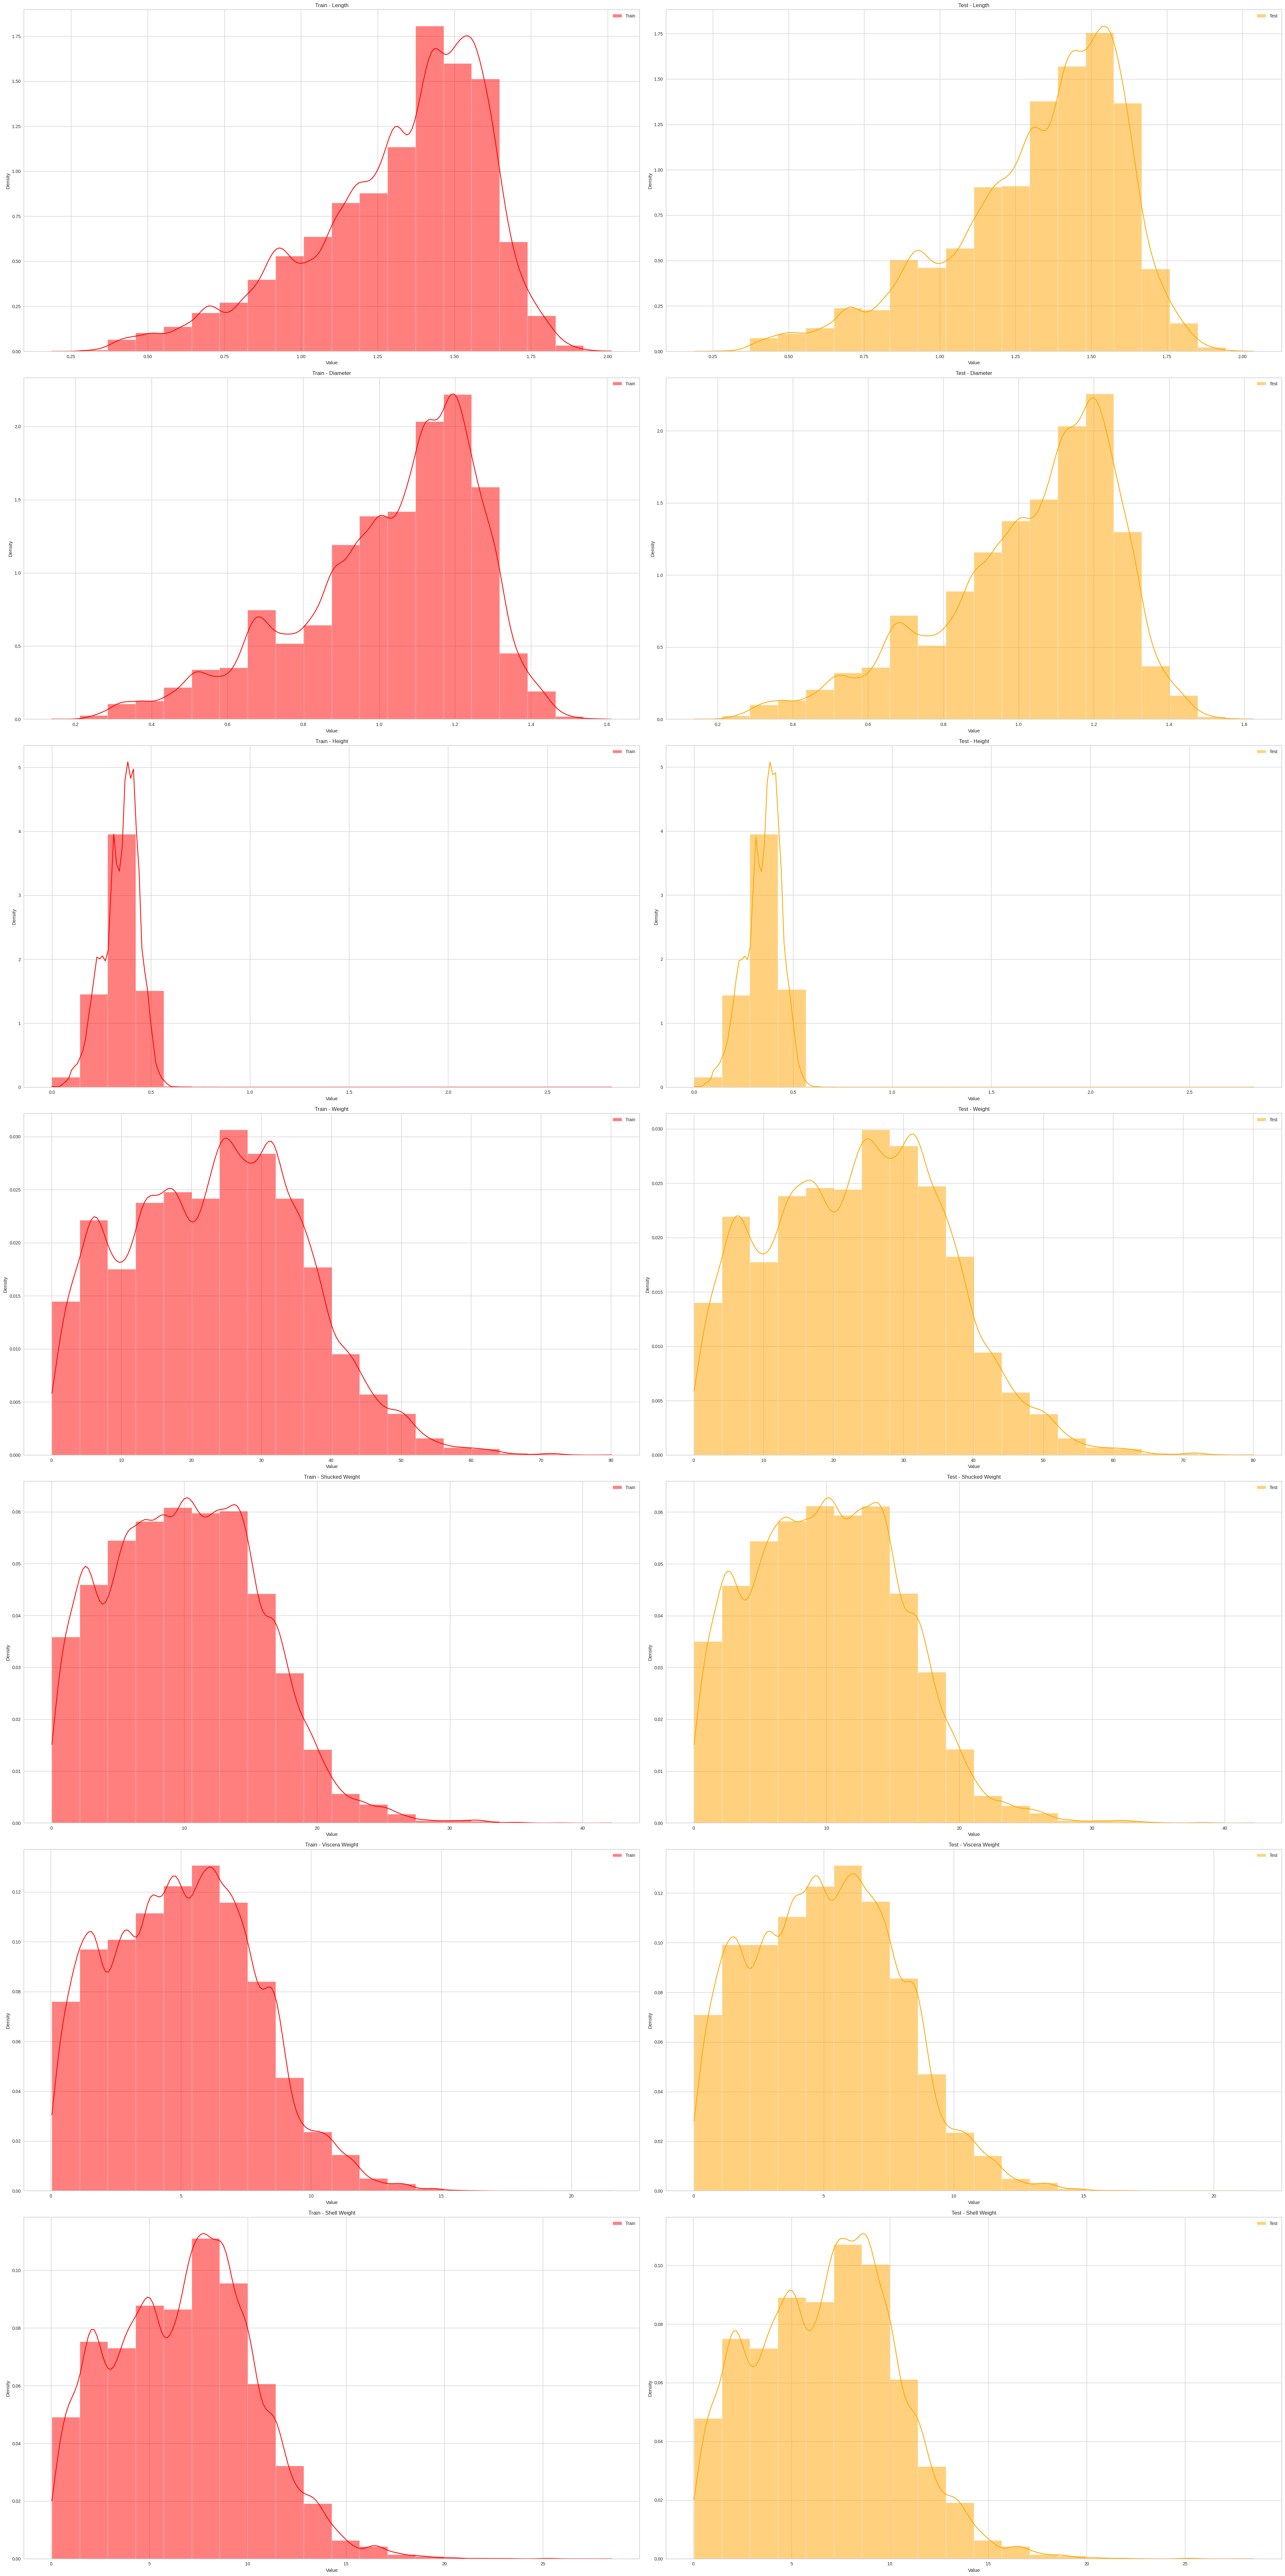

In [10]:
cont_cols=[f for f in train_data.columns if train_data[f].dtype in [float,int] and train_data[f].nunique()>50 and f not in ['Age']]

# Create subplots for each continuous column
fig, axs = plt.subplots(len(cont_cols), 2, figsize=(40,80))

# Loop through each continuous column and plot the histograms
for i, col in enumerate(cont_cols):
    # Determine the range of values to plot
    max_val = max(train_data[col].max(), test_data[col].max())
    min_val = min(train_data[col].min(), test_data[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins_train = round(range_val / bin_size)
    num_bins_test = round(range_val / bin_size)

    # Plot the histograms
    sns.histplot(train_data[col],stat='density', ax=axs[i][0], color='red', kde=True, label='Train', bins=num_bins_train)
    sns.histplot(test_data[col],stat='density', ax=axs[i][1], color='orange', kde=True, label='Test', bins=num_bins_test)
    axs[i][0].set_title(f'Train - {col}')
    axs[i][0].set_xlabel('Value')
    axs[i][0].set_ylabel('Density')
    axs[i][1].set_title(f'Test - {col}')
    axs[i][1].set_xlabel('Value')
    axs[i][1].set_ylabel('Density')
    axs[i][0].legend()
    axs[i][1].legend()

plt.tight_layout()
plt.show()

# 4. Discrete Features Analysis

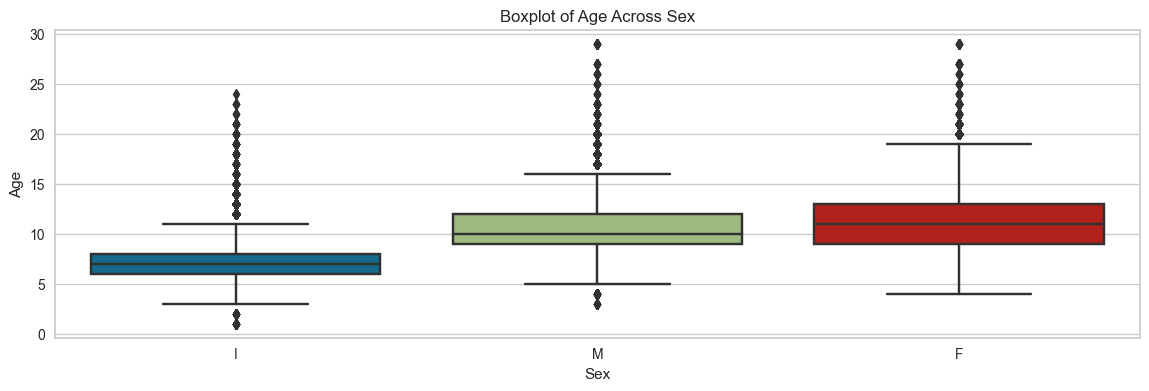

In [8]:
cat_cols=[f for f in train_data.columns if f not in ["Age"] and train_data[f].nunique()<=15]
for var in cat_cols:
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=var, y='Age', data=train_data, ax=ax)
    ax.set_title(f'Boxplot of Age Across {var}')
    plt.show()

# 5. Feature Engineering

Add features recommended by GPT4:

Volume: length * diameter * height
Weight_ratio: weight / (shucked weight + viscera weight + shell weight)
Shucked_weight_ratio: shucked weight / weight
Viscera_weight_ratio: viscera weight / weight
Shell_weight_ratio: shell weight / weight
Length_diameter_ratio: length / diameter
Length_height_ratio: length / height
Diameter_height_ratio: diameter / height
Surface_area: 2 * (length * diameter + length * height + diameter * height)
Density: weight / volume
Shucked_density: shucked weight / volume
Viscera_density: viscera weight / volume
Shell_density: shell weight / volume

In [11]:
def add_features(df):
    height_values = df['Height'].clip(lower=0.001)
    df['Volume'] = df.Length * df.Diameter * height_values
    df['Weight_ratio'] = df.Weight / (df['Shucked Weight'] + df['Viscera Weight'] + df['Shell Weight'])
    df['Shucked_weight_ratio'] = df['Shucked Weight'] / df['Weight']
    df['Viscera_weight_ratio'] = df['Viscera Weight'] / df['Weight']
    df['Shell_weight_ratio'] = df['Shell Weight'] / df['Weight']
    df['Length_diameter_ratio'] = df['Length'] / df['Diameter']
    df['Length_height_ratio'] = df['Length'] / height_values
    df['Diameter_height_ratio'] = df['Diameter'] / height_values
    df['Surface_area'] = 2 * (df.Length * df.Diameter + df.Length * height_values + df.Diameter * height_values)
    df['Density'] = df.Weight / df.Volume
    df['Shucked_density'] = df['Shucked Weight'] / df.Volume
    df['Viscera_density'] = df['Viscera Weight'] / df.Volume
    df['Shell_density'] = df['Shell Weight'] / df.Volume

In [12]:
add_features(train_data)
add_features(test_data)

Transformations

In [13]:
cont_cols=[f for f in train_data.columns if train_data[f].dtype!='O' and f not in ["Age"] and train_data[f].nunique()>2]

sc=MinMaxScaler()
unimportant_features=[]
table = PrettyTable()
table.field_names = ['Feature', 'Original RMSE(CV-TRAIN)', 'Transformed Feature', 'Tranformed RMSE(CV-TRAIN)']


for col in cont_cols:
    # Log Transformation after MinMax Scaling(keeps data between 0 and 1)
    train_data["log_"+col]=np.log1p(sc.fit_transform(train_data[[col]]))
    test_data["log_"+col]=np.log1p(sc.transform(test_data[[col]]))

    # Square Root Transformation
    train_data["sqrt_"+col]=np.sqrt(sc.fit_transform(train_data[[col]]))
    test_data["sqrt_"+col]=np.sqrt(sc.transform(test_data[[col]]))

    # Box-Cox transformation
    combined_data = pd.concat([train_data[[col]], test_data[[col]]], axis=0)
    transformer = PowerTransformer(method='box-cox')
    # Apply scaling and transformation on the combined data
    scaled_data = sc.fit_transform(combined_data)+1
    transformed_data = transformer.fit_transform(scaled_data)

    # Assign the transformed values back to train_data and test_data data
    train_data["bx_cx_" + col] = transformed_data[:train_data.shape[0]]
    test_data["bx_cx_" + col] = transformed_data[train_data.shape[0]:]

    # Yeo-Johnson transformation
    transformer = PowerTransformer(method='yeo-johnson')
    train_data["y_J_"+col] = transformer.fit_transform(train_data[[col]])
    test_data["y_J_"+col] = transformer.transform(test_data[[col]])

    # Power transformation, 0.25
    power_transform = lambda x: np.power(x + 1 - np.min(x), 0.25)
    transformer = FunctionTransformer(power_transform)
    train_data["pow_"+col] = transformer.fit_transform(sc.fit_transform(train_data[[col]]))
    test_data["pow_"+col] = transformer.transform(sc.transform(test_data[[col]]))

    # Power transformation, 0.1
    power_transform = lambda x: np.power(x + 1 - np.min(x), 2)
    transformer = FunctionTransformer(power_transform)
    train_data["pow2_"+col] = transformer.fit_transform(sc.fit_transform(train_data[[col]]))
    test_data["pow2_"+col] = transformer.transform(sc.transform(test_data[[col]]))

    # log to power transformation
    train_data["log_pow2"+col]=np.log1p(train_data["pow2_"+col])
    test_data["log_pow2"+col]=np.log1p(test_data["pow2_"+col])

    temp_cols=[col,"log_"+col,"sqrt_"+col, "bx_cx_"+col,"y_J_"+col ,"pow_"+col,"pow2_"+col,"log_pow2"+col ]

    # Fill na because it would be Nan if the values are negative and a transformation applied on it
    train_data[temp_cols]=train_data[temp_cols].fillna(0)
    test_data[temp_cols]=test_data[temp_cols].fillna(0)

    #Apply PCA on  the features and compute an additional column
    pca=TruncatedSVD(n_components=1)
    x_pca_train_data=pca.fit_transform(train_data[temp_cols])
    x_pca_test_data=pca.transform(test_data[temp_cols])
    x_pca_train_data=pd.DataFrame(x_pca_train_data, columns=[col+"_pca_comb"])
    x_pca_test_data=pd.DataFrame(x_pca_test_data, columns=[col+"_pca_comb"])
    temp_cols.append(col+"_pca_comb")
    #print(temp_cols)
    test_data=test_data.reset_index(drop=True) # to combine with pca feature

    train_data=pd.concat([train_data,x_pca_train_data],axis='columns')
    test_data=pd.concat([test_data,x_pca_test_data],axis='columns')

    # See which transformation along with the original is giving you the best univariant fit with target
    kf=KFold(n_splits=5, shuffle=True, random_state=42)

    MAE=[]

    for f in temp_cols:
        X=train_data[[f]].values
        y=train_data["Age"].values

        mae=[]
        for train_data_idx, val_idx in kf.split(X,y):
            X_train_data,y_train_data=X[train_data_idx],y[train_data_idx]
            x_val,y_val=X[val_idx],y[val_idx]

            model=LinearRegression()
            model.fit(X_train_data,y_train_data)
            y_pred=model.predict(x_val)
            mae.append(rmse(y_val,y_pred))
        MAE.append((f,np.mean(mae)))
        if f==col:
            orig_mae=np.mean(mae)
    best_col, best_acc=sorted(MAE, key=lambda x:x[1], reverse=False)[0]

    # cols_to_drop = [f for f in temp_cols if  f!= best_col and f not in col]
#     print(cols_to_drop)
#     final_selection=[f for f in temp_cols if f not in cols_to_drop]
    if cols_to_drop := [f for f in temp_cols if  f!= best_col and f not in col]:
        unimportant_features += cols_to_drop
#         train_data=train_data.drop(columns=cols_to_drop)
#         test_data=test_data.drop(columns=cols_to_drop)

    table.add_row([col,orig_mae,best_col ,best_acc])
print(table)

+-----------------------+-------------------------+-----------------------------+---------------------------+
|        Feature        | Original RMSE(CV-TRAIN) |     Transformed Feature     | Tranformed RMSE(CV-TRAIN) |
+-----------------------+-------------------------+-----------------------------+---------------------------+
|         Length        |    2.5089844473593095   |        log_pow2Length       |     2.5076538209669175    |
|        Diameter       |    2.4880598776892593   |       log_pow2Diameter      |     2.487179718732874     |
|         Height        |    2.4454335141764063   |          log_Height         |     2.435209734417941     |
|         Weight        |    2.5372942140695995   |         sqrt_Weight         |     2.4688165193800247    |
|     Shucked Weight    |    2.7436180932809244   |     sqrt_Shucked Weight     |     2.6498939151086853    |
|     Viscera Weight    |    2.5937633239540565   |     sqrt_Viscera Weight     |     2.513522208314093     |
|      She

Discrete columns encoding

In [14]:
discrete_cols=[f for f in train_data.columns if train_data[f].dtype=='O' ]

In [15]:
def OHE(train,test,cols,target):
    combined = pd.concat([train, test], axis=0)
    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.drop(col, axis=1)
        combined = combined.loc[:, ~combined.columns.duplicated()]

    # split back to train and test dataframes
    train_ohe = combined[:len(train)]
    test_ohe = combined[len(train):]
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)

    return train_ohe, test_ohe

table = PrettyTable()
table.field_names = ['Feature', 'Encoded Features', 'RMSE']

for feature in discrete_cols:
    ## Target Guided Mean --Data Leakage Possible

    cat_labels=train_data.groupby([feature])['Age'].mean().sort_values().index
    cat_labels2={k:i for i,k in enumerate(cat_labels,0)}
    train_data[feature+"_target"]=train_data[feature].map(cat_labels2)
    test_data[feature+"_target"]=test_data[feature].map(cat_labels2)

    ## Count Encoding

    dic=train_data[feature].value_counts().to_dict()
    train_data[feature+"_count"]=np.log1p(train_data[feature].map(dic))
    test_data[feature+"_count"]=np.log1p(test_data[feature].map(dic))


    ## Count Labeling

    dic2=train_data[feature].value_counts().to_dict()
    list1=np.arange(len(dic2.values()),0,-1) # Higher rank for high count
    # list1=np.arange(len(dic2.values())) # Higher rank for low count
    dic3=dict(zip(list(dic2.keys()),list1))
    train_data[feature+"_count_label"]=train_data[feature].replace(dic3)
    test_data[feature+"_count_label"]=test_data[feature].replace(dic3)



    temp_cols=[feature+"_target", feature+"_count", feature+"_count_label"]
    if train_data[feature].dtype!="O":
        temp_cols.append(feature)
    else:
        train_data, test_data=OHE(train_data,test_data,[feature],"Age")

    # See which transformation along with the original is giving you the best univariate fit with target
    kf=KFold(n_splits=10, shuffle=True, random_state=42)

    MAE=[]

    for f in temp_cols:
        X=train_data[[f]].values
        y=train_data["Age"].values

        mae=[]
        for train_data_idx, val_idx in kf.split(X,y):
            X_train_data,y_train_data=X[train_data_idx],y[train_data_idx]
            x_val,y_val=X[val_idx],y[val_idx]

            model=LinearRegression()
            model.fit(X_train_data,y_train_data)
            y_pred=model.predict(x_val)
            mae.append(rmse(y_val,y_pred))
        MAE.append((f,np.mean(mae)))
    best_col, best_acc=sorted(MAE, key=lambda x:x[1], reverse=False)[0]

    # check correlation between best_col and other columns and drop if correlation >0.75
    corr = train_data[temp_cols].corr(method='pearson')
    corr_with_best_col = corr[best_col]
    cols_to_drop = [f for f in temp_cols if corr_with_best_col[f] > 0.3 and f != best_col]
    final_selection=[f for f in temp_cols if f not in cols_to_drop]
    if cols_to_drop:
        train_data = train_data.drop(columns=cols_to_drop)
        test_data = test_data.drop(columns=cols_to_drop)

    table.add_row([feature,final_selection,best_acc])
print(table)

+---------+------------------------------------------------+--------------------+
| Feature |                Encoded Features                |        RMSE        |
+---------+------------------------------------------------+--------------------+
|   Sex   | ['Sex_target', 'Sex_count', 'Sex_count_label'] | 2.7991967413578904 |
+---------+------------------------------------------------+--------------------+


clusting one-hot transformations

['log_Length', 'sqrt_Length', 'bx_cx_Length', 'y_J_Length', 'pow_Length', 'pow2_Length', 'Length_pca_comb', 'sqrt_Length_diameter_ratio', 'bx_cx_Length_diameter_ratio', 'y_J_Length_diameter_ratio', 'pow_Length_diameter_ratio', 'pow2_Length_diameter_ratio', 'log_pow2Length_diameter_ratio', 'Length_diameter_ratio_pca_comb', 'log_Length_height_ratio', 'sqrt_Length_height_ratio', 'y_J_Length_height_ratio', 'pow_Length_height_ratio', 'pow2_Length_height_ratio', 'log_pow2Length_height_ratio', 'Length_height_ratio_pca_comb']


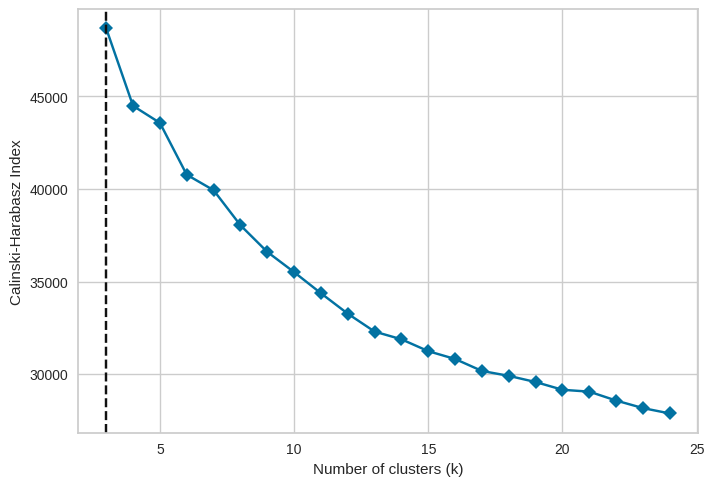

['log_Diameter', 'sqrt_Diameter', 'bx_cx_Diameter', 'y_J_Diameter', 'pow_Diameter', 'pow2_Diameter', 'Diameter_pca_comb', 'log_Diameter_height_ratio', 'sqrt_Diameter_height_ratio', 'y_J_Diameter_height_ratio', 'pow_Diameter_height_ratio', 'pow2_Diameter_height_ratio', 'log_pow2Diameter_height_ratio', 'Diameter_height_ratio_pca_comb']


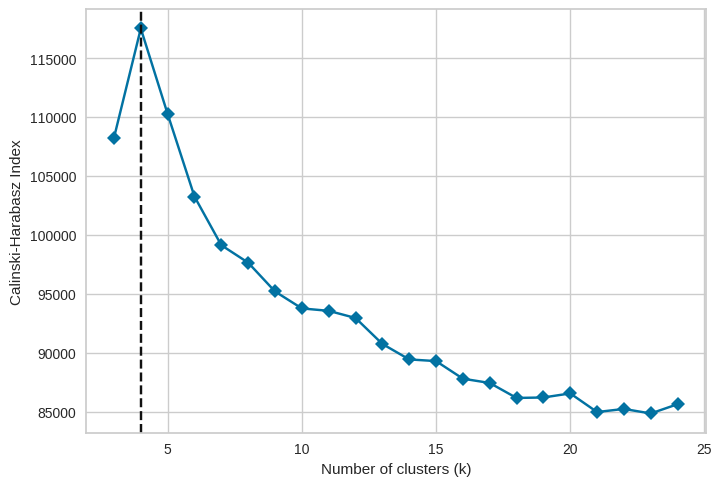

['sqrt_Height', 'bx_cx_Height', 'y_J_Height', 'pow_Height', 'pow2_Height', 'log_pow2Height', 'Height_pca_comb']


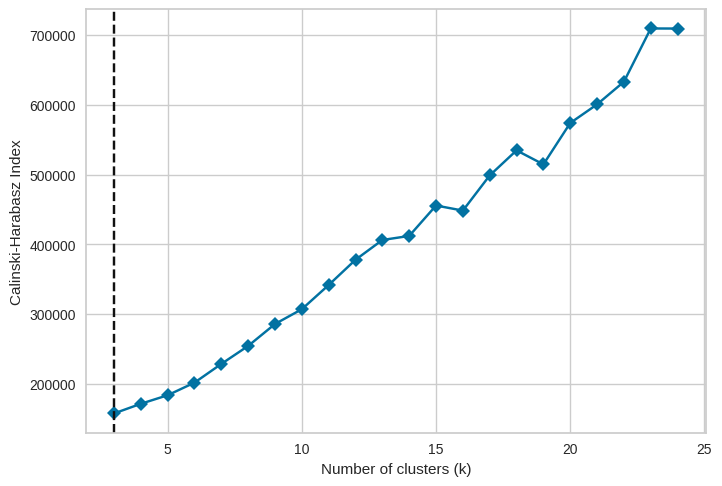

['log_Weight', 'bx_cx_Weight', 'y_J_Weight', 'pow_Weight', 'pow2_Weight', 'log_pow2Weight', 'Weight_pca_comb', 'log_Shucked Weight', 'bx_cx_Shucked Weight', 'y_J_Shucked Weight', 'pow_Shucked Weight', 'pow2_Shucked Weight', 'log_pow2Shucked Weight', 'Shucked Weight_pca_comb', 'log_Viscera Weight', 'bx_cx_Viscera Weight', 'y_J_Viscera Weight', 'pow_Viscera Weight', 'pow2_Viscera Weight', 'log_pow2Viscera Weight', 'Viscera Weight_pca_comb', 'log_Shell Weight', 'bx_cx_Shell Weight', 'y_J_Shell Weight', 'pow_Shell Weight', 'pow2_Shell Weight', 'log_pow2Shell Weight', 'Shell Weight_pca_comb', 'log_Weight_ratio', 'sqrt_Weight_ratio', 'y_J_Weight_ratio', 'pow_Weight_ratio', 'pow2_Weight_ratio', 'log_pow2Weight_ratio', 'Weight_ratio_pca_comb']


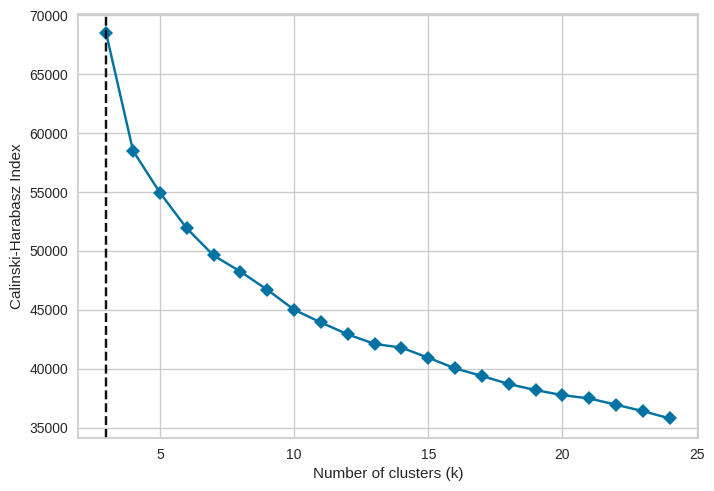

['log_Shucked Weight', 'bx_cx_Shucked Weight', 'y_J_Shucked Weight', 'pow_Shucked Weight', 'pow2_Shucked Weight', 'log_pow2Shucked Weight', 'Shucked Weight_pca_comb']


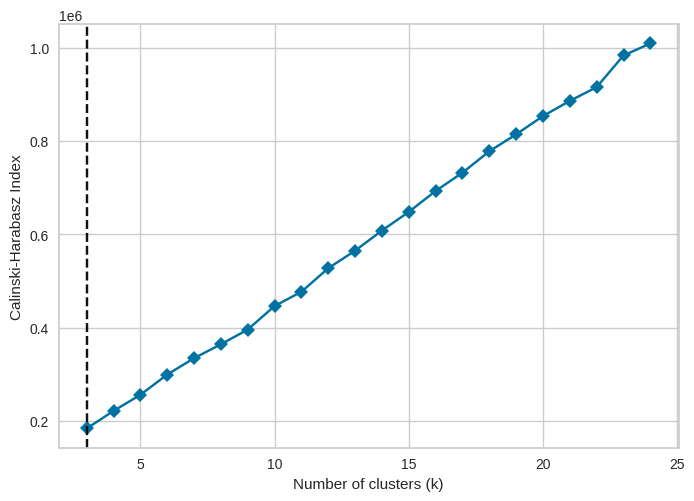

['log_Viscera Weight', 'bx_cx_Viscera Weight', 'y_J_Viscera Weight', 'pow_Viscera Weight', 'pow2_Viscera Weight', 'log_pow2Viscera Weight', 'Viscera Weight_pca_comb']


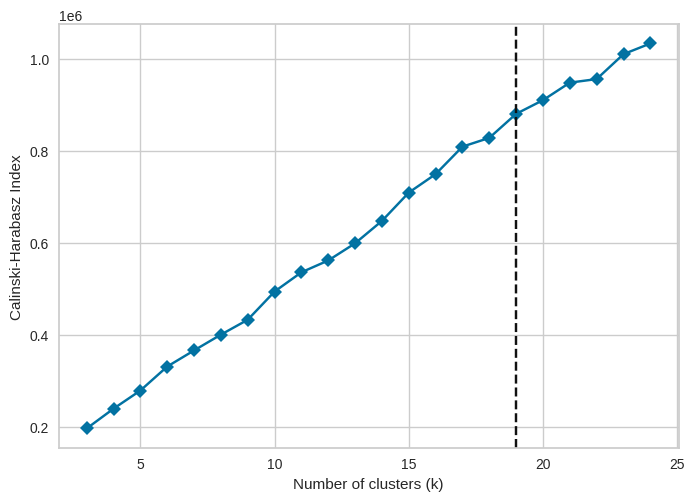

['log_Shell Weight', 'bx_cx_Shell Weight', 'y_J_Shell Weight', 'pow_Shell Weight', 'pow2_Shell Weight', 'log_pow2Shell Weight', 'Shell Weight_pca_comb']


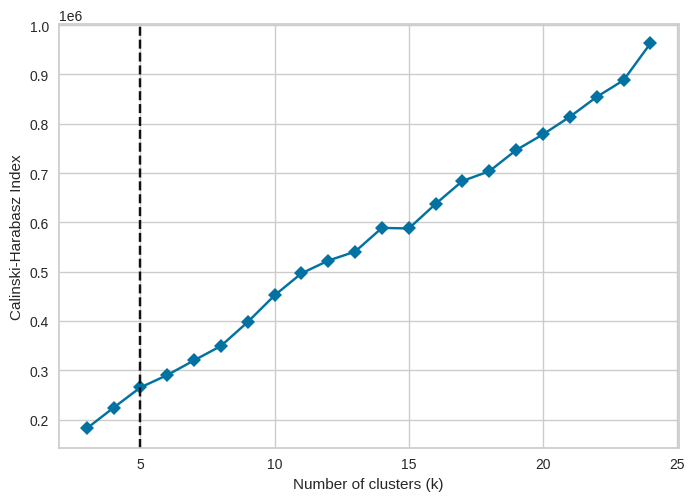

['log_Volume', 'bx_cx_Volume', 'y_J_Volume', 'pow_Volume', 'pow2_Volume', 'log_pow2Volume', 'Volume_pca_comb']


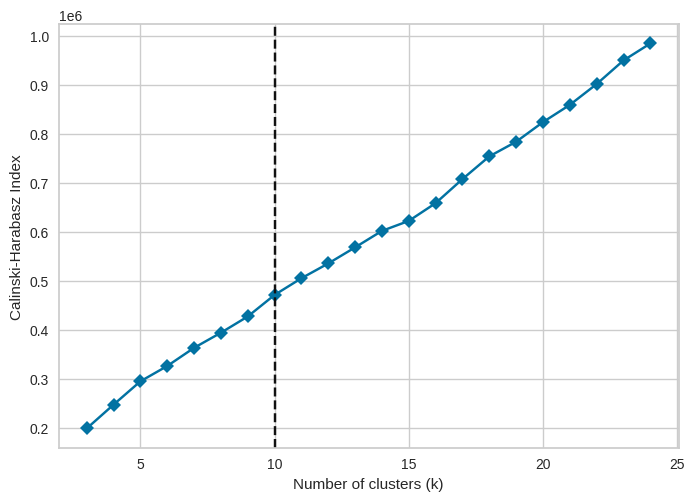

['log_Weight_ratio', 'sqrt_Weight_ratio', 'y_J_Weight_ratio', 'pow_Weight_ratio', 'pow2_Weight_ratio', 'log_pow2Weight_ratio', 'Weight_ratio_pca_comb']


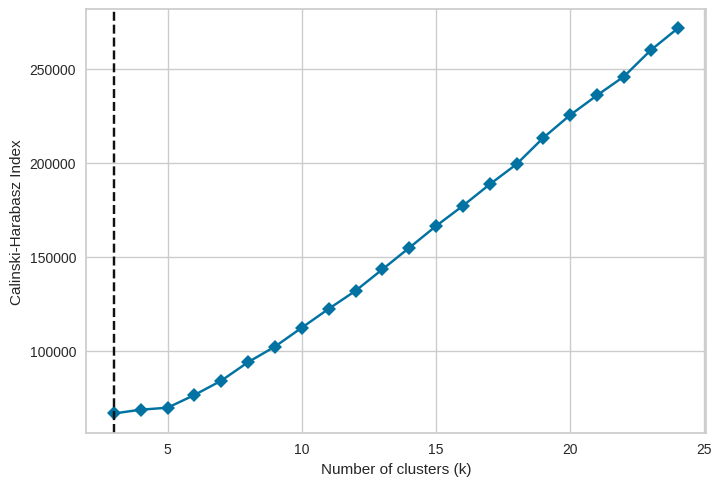

['log_Shucked_weight_ratio', 'sqrt_Shucked_weight_ratio', 'y_J_Shucked_weight_ratio', 'pow_Shucked_weight_ratio', 'pow2_Shucked_weight_ratio', 'log_pow2Shucked_weight_ratio', 'Shucked_weight_ratio_pca_comb']


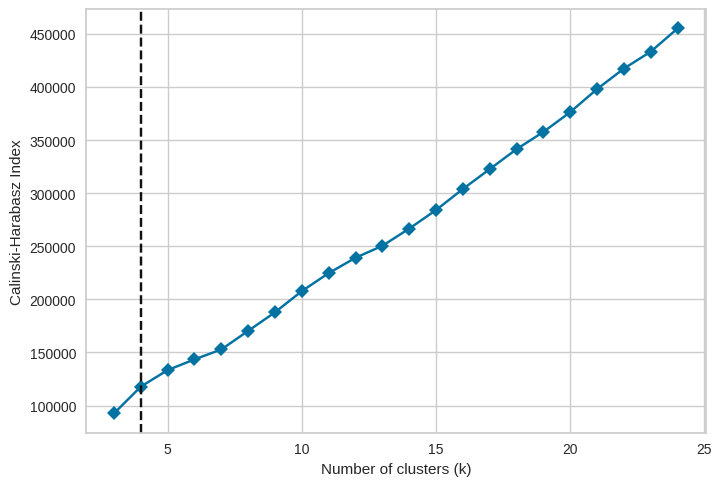

['log_Viscera_weight_ratio', 'sqrt_Viscera_weight_ratio', 'bx_cx_Viscera_weight_ratio', 'y_J_Viscera_weight_ratio', 'pow_Viscera_weight_ratio', 'log_pow2Viscera_weight_ratio', 'Viscera_weight_ratio_pca_comb']


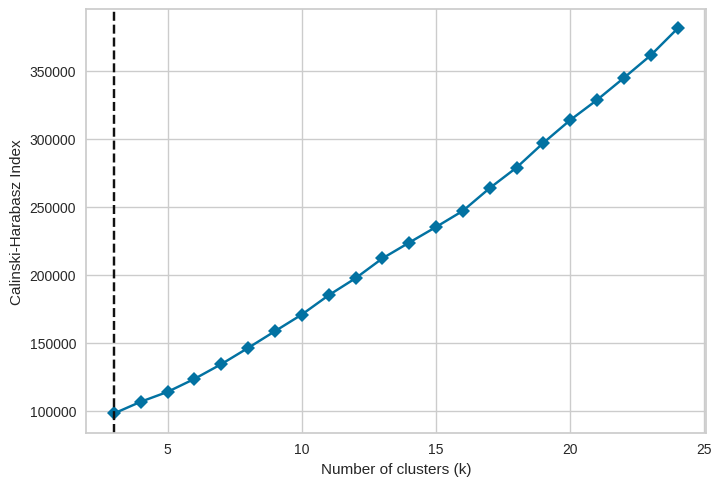

['log_Shell_weight_ratio', 'sqrt_Shell_weight_ratio', 'y_J_Shell_weight_ratio', 'pow_Shell_weight_ratio', 'pow2_Shell_weight_ratio', 'log_pow2Shell_weight_ratio', 'Shell_weight_ratio_pca_comb']


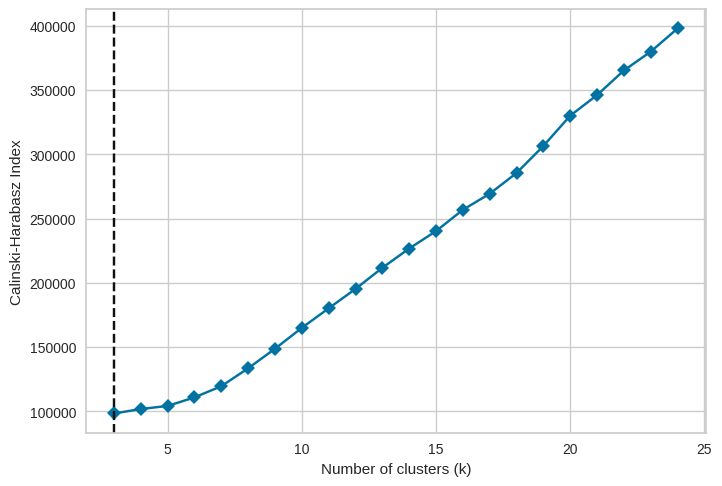

['sqrt_Length_diameter_ratio', 'bx_cx_Length_diameter_ratio', 'y_J_Length_diameter_ratio', 'pow_Length_diameter_ratio', 'pow2_Length_diameter_ratio', 'log_pow2Length_diameter_ratio', 'Length_diameter_ratio_pca_comb']


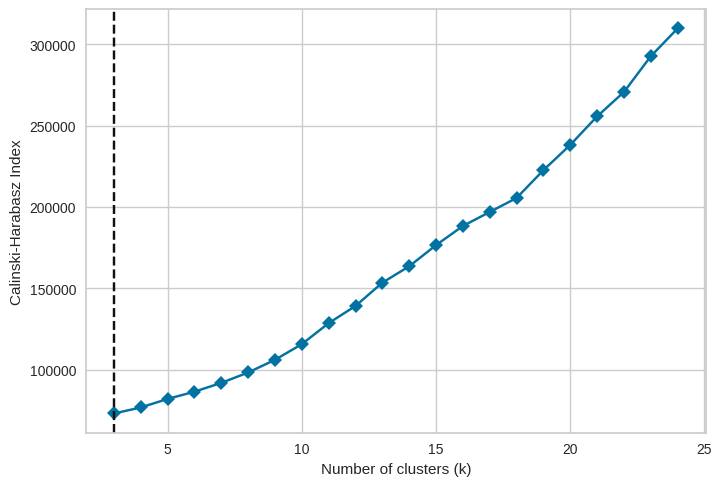

['log_Length_height_ratio', 'sqrt_Length_height_ratio', 'y_J_Length_height_ratio', 'pow_Length_height_ratio', 'pow2_Length_height_ratio', 'log_pow2Length_height_ratio', 'Length_height_ratio_pca_comb']


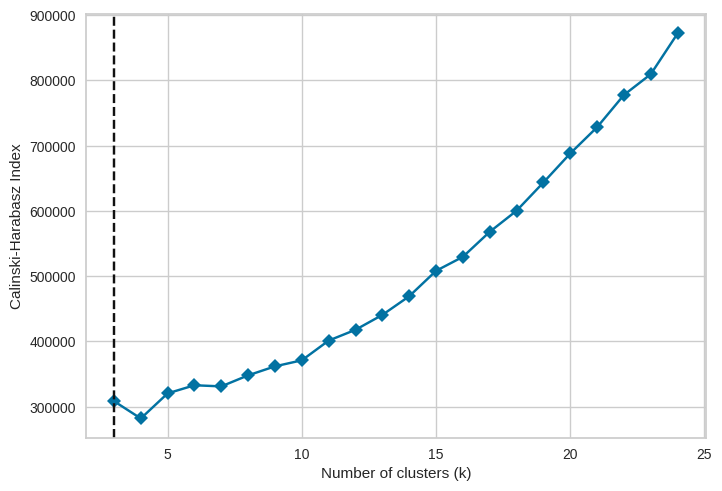

['log_Diameter_height_ratio', 'sqrt_Diameter_height_ratio', 'y_J_Diameter_height_ratio', 'pow_Diameter_height_ratio', 'pow2_Diameter_height_ratio', 'log_pow2Diameter_height_ratio', 'Diameter_height_ratio_pca_comb']


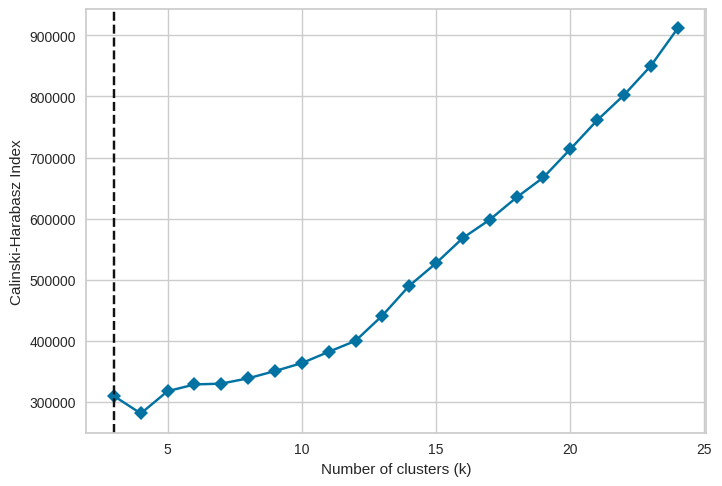

['log_Surface_area', 'bx_cx_Surface_area', 'y_J_Surface_area', 'pow_Surface_area', 'pow2_Surface_area', 'log_pow2Surface_area', 'Surface_area_pca_comb']


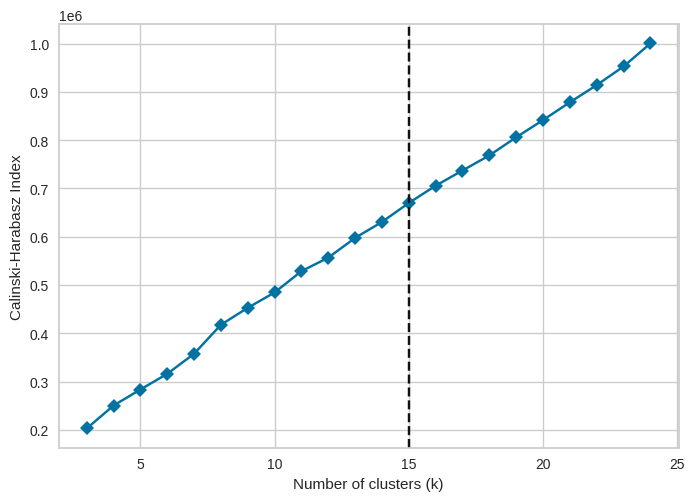

['log_Density', 'sqrt_Density', 'y_J_Density', 'pow_Density', 'pow2_Density', 'log_pow2Density', 'Density_pca_comb']


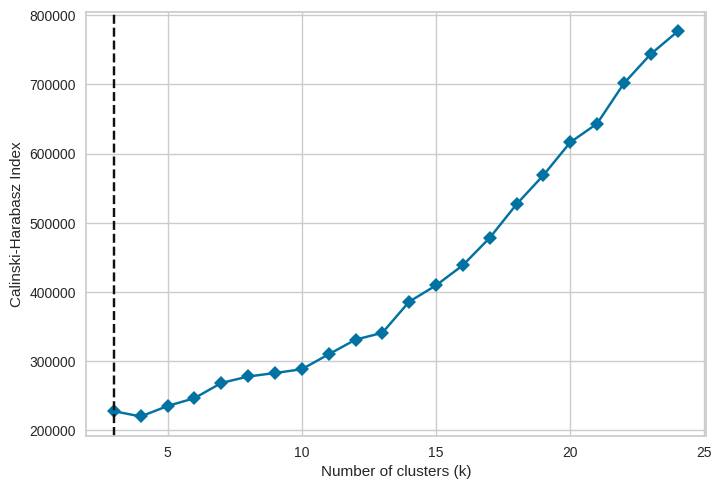

['log_Shucked_density', 'sqrt_Shucked_density', 'y_J_Shucked_density', 'pow_Shucked_density', 'pow2_Shucked_density', 'log_pow2Shucked_density', 'Shucked_density_pca_comb']


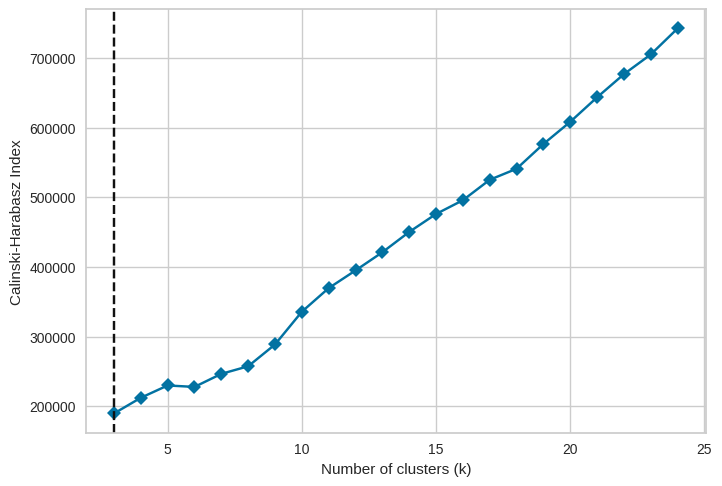

['log_Viscera_density', 'sqrt_Viscera_density', 'y_J_Viscera_density', 'pow_Viscera_density', 'pow2_Viscera_density', 'log_pow2Viscera_density', 'Viscera_density_pca_comb']


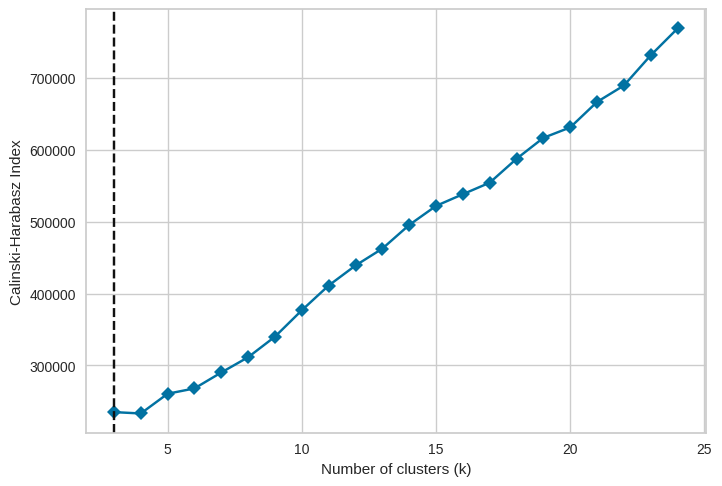

['log_Shell_density', 'sqrt_Shell_density', 'y_J_Shell_density', 'pow_Shell_density', 'pow2_Shell_density', 'log_pow2Shell_density', 'Shell_density_pca_comb']


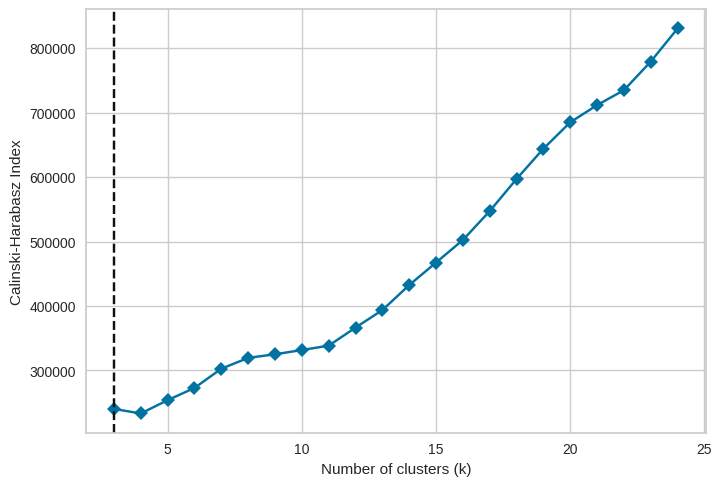

+-----------------------------------------+---------------------+
|           Cluster WOE Feature           | RMSE(CV-train_data) |
+-----------------------------------------+---------------------+
|         Length_unimp_cluster_WOE        |  2.7258000120822024 |
|        Diameter_unimp_cluster_WOE       |  2.593544255309921  |
|         Height_unimp_cluster_WOE        |  2.546307858453035  |
|         Weight_unimp_cluster_WOE        |  2.607635948377631  |
|     Shucked Weight_unimp_cluster_WOE    |  2.7212761739771176 |
|     Viscera Weight_unimp_cluster_WOE    |  2.5023601268605646 |
|      Shell Weight_unimp_cluster_WOE     |  2.430412454142714  |
|         Volume_unimp_cluster_WOE        |  2.468289000522853  |
|      Weight_ratio_unimp_cluster_WOE     |  3.136200987794435  |
|  Shucked_weight_ratio_unimp_cluster_WOE |  3.084224948026762  |
|  Viscera_weight_ratio_unimp_cluster_WOE |  3.169726167428719  |
|   Shell_weight_ratio_unimp_cluster_WOE  |  3.1625232226956603 |
| Length_d

In [16]:
table = PrettyTable()
table.field_names = ['Cluster WOE Feature', 'RMSE(CV-train_data)']
for col in cont_cols:
    sub_set=[f for f in unimportant_features if col in f]
    print(sub_set)
    temp_train_data=train_data[sub_set]
    temp_test_data=test_data[sub_set]
    sc=StandardScaler()
    temp_train_data=sc.fit_transform(temp_train_data)
    temp_test_data=sc.transform(temp_test_data)
    model = KMeans()


    # Initialize the KElbowVisualizer with the KMeans model and desired range of clusters
    visualizer = KElbowVisualizer(model, k=(3, 25), metric='calinski_harabasz', timings=False)

    # Fit the visualizer to the data
    visualizer.fit(np.array(temp_train_data))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Calinski-Harabasz Index')
    plt.show()

    ideal_clusters = visualizer.elbow_value_
    if ideal_clusters is None:
        print("No elbow!!!")
        continue
    # print(ideal_clusters)
    kmeans = KMeans(n_clusters=ideal_clusters)
    kmeans.fit(np.array(temp_train_data))
    labels_train_data = kmeans.labels_

    train_data[col+'_OHE_cluster'] = labels_train_data
    test_data[col+'_OHE_cluster'] = kmeans.predict(np.array(temp_test_data))
    # Also, making a copy to do mean encoding followed by a log transformation
    
    train_data[col+"_unimp_cluster_WOE"]=train_data[col+'_OHE_cluster']
    test_data[col+"_unimp_cluster_WOE"]=test_data[col+'_OHE_cluster'] 
    cat_labels=np.log1p(train_data.groupby([col+"_unimp_cluster_WOE"])['Age'].mean())
    cat_labels2=cat_labels.to_dict()
    train_data[col+"_unimp_cluster_WOE"]=train_data[col+"_unimp_cluster_WOE"].map(cat_labels2)
    test_data[col+"_unimp_cluster_WOE"]=test_data[col+"_unimp_cluster_WOE"].map(cat_labels2)

    X=train_data[[col+"_unimp_cluster_WOE"]].values
    y=train_data["Age"].values

    mae=[]
    for train_data_idx, val_idx in kf.split(X,y):
        X_train_data,y_train_data=X[train_data_idx],y[train_data_idx]
        x_val,y_val=X[val_idx],y[val_idx]

        model=LinearRegression()
        model.fit(X_train_data,y_train_data)
        y_pred=model.predict(x_val)
        mae.append(rmse(y_val,y_pred))
    table.add_row([col+"_unimp_cluster_WOE",np.mean(mae)])
    
    train_data[col+'_OHE_cluster']=col+"_OHE_"+train_data[col+'_OHE_cluster'].astype(str)
    test_data[col+'_OHE_cluster']=col+"_OHE_"+test_data[col+'_OHE_cluster'].astype(str)
    train_data, test_data=OHE(train_data,test_data,[col+'_OHE_cluster'],"Age")
print(table)

features selection

In [ ]:
# corr = train_data.corr()
# plt.figure(figsize = (40, 40), dpi = 300)
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(corr, mask = mask, cmap = sns.diverging_palette(500, 10, as_cmap=True), annot = True, annot_kws = {'size' : 7})
# plt.title('Correlation Matrix\n', fontsize = 25, weight = 'bold')
# plt.show()

Remove correlations

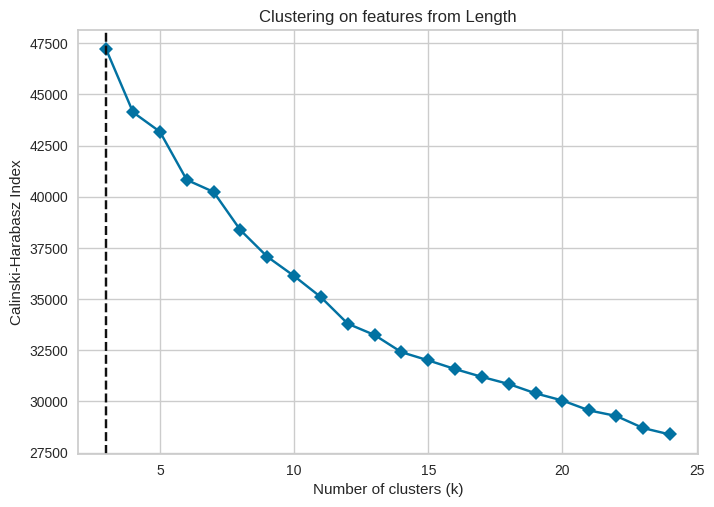

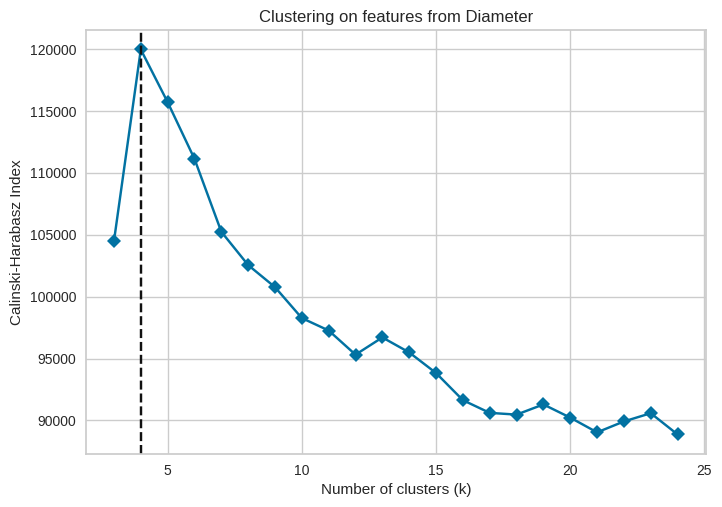

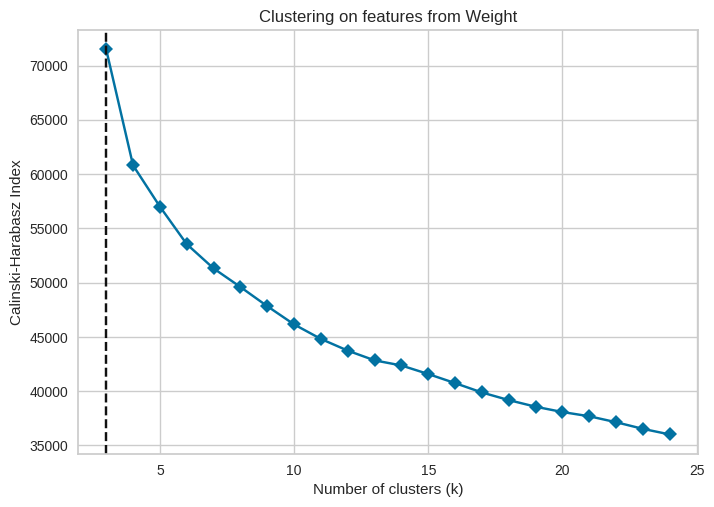

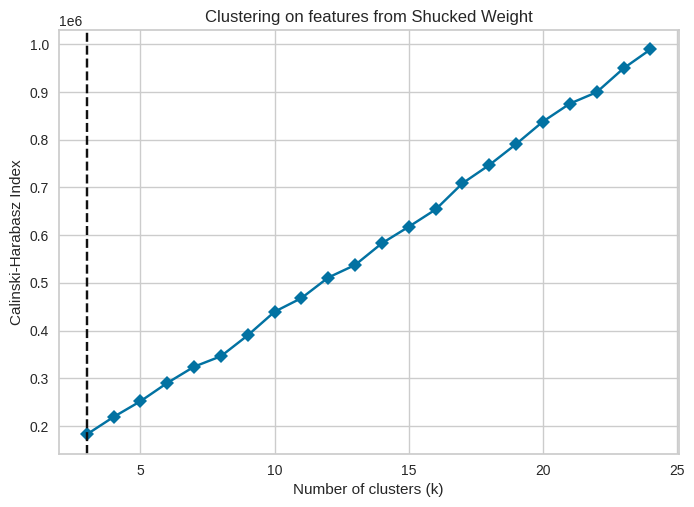

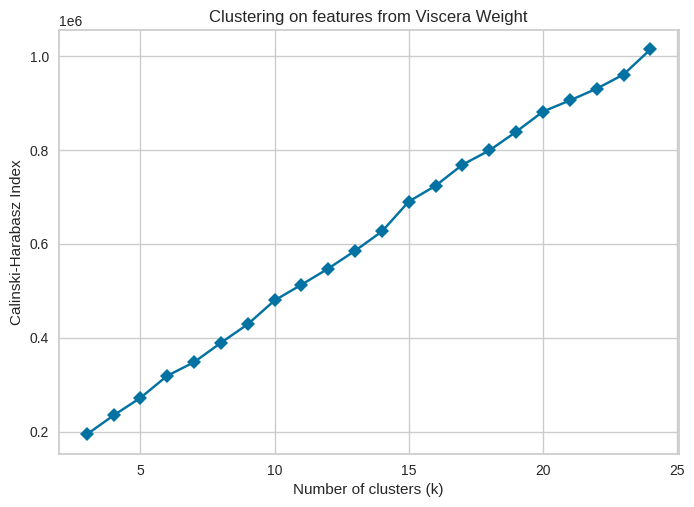

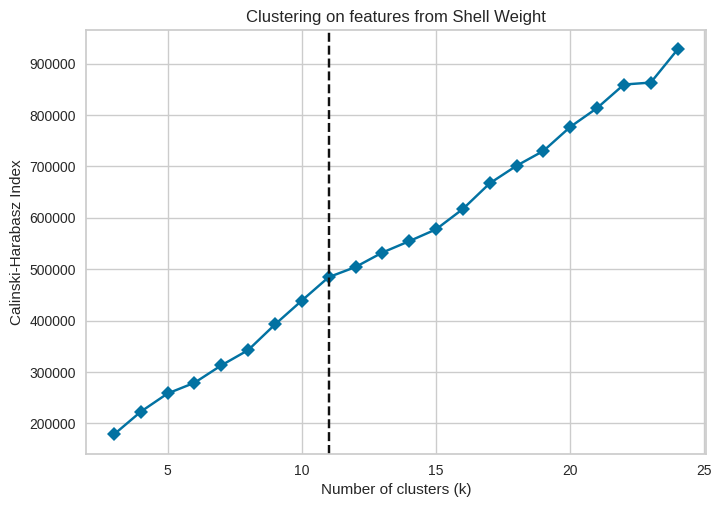

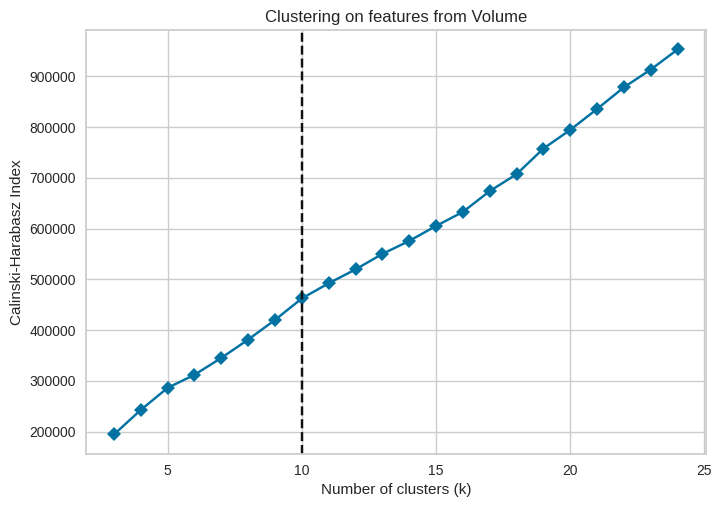

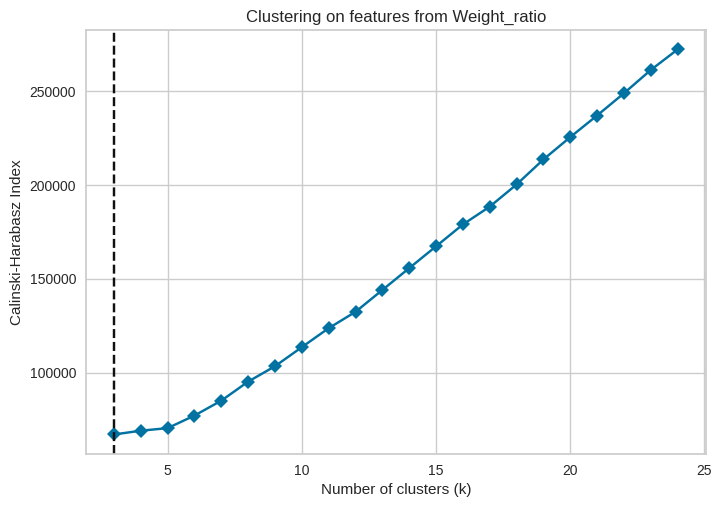

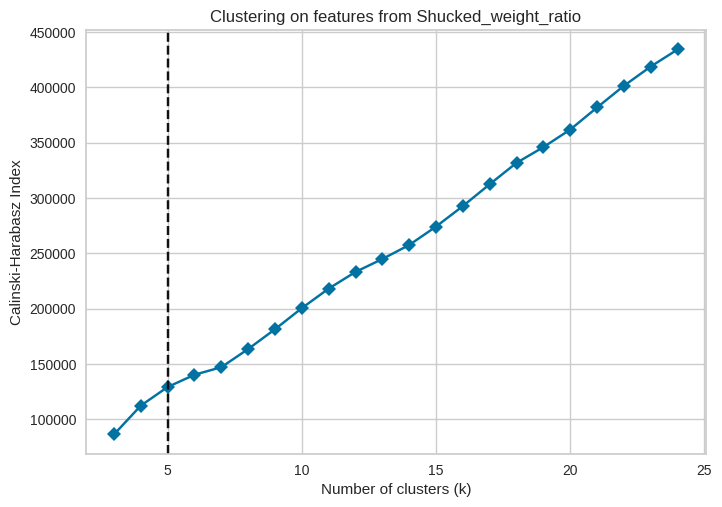

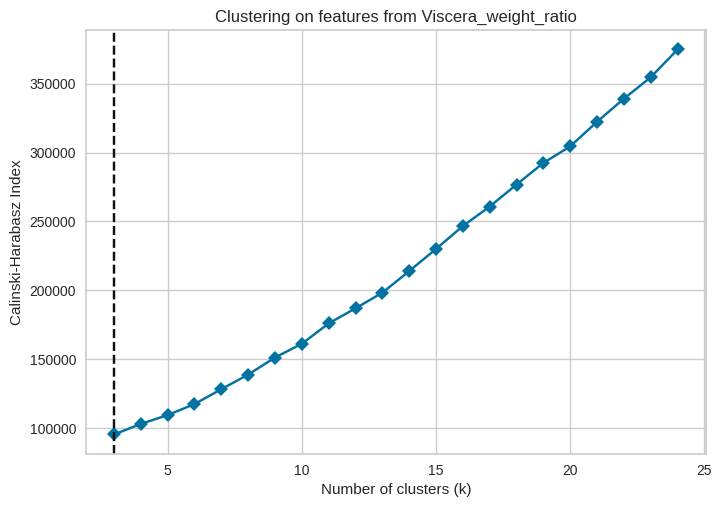

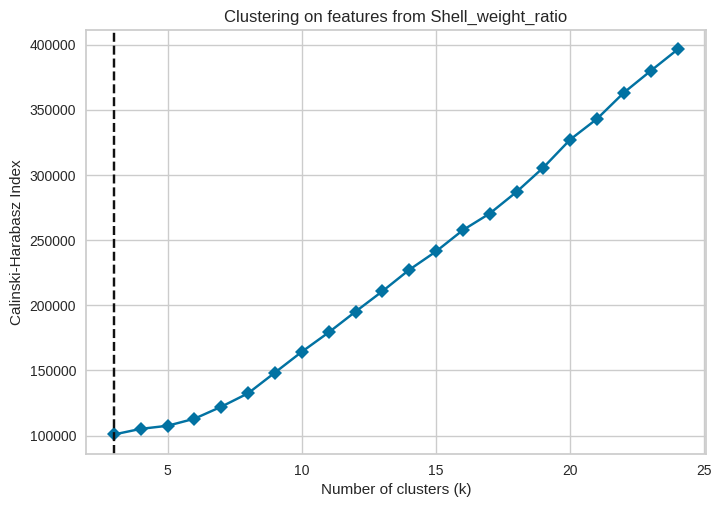

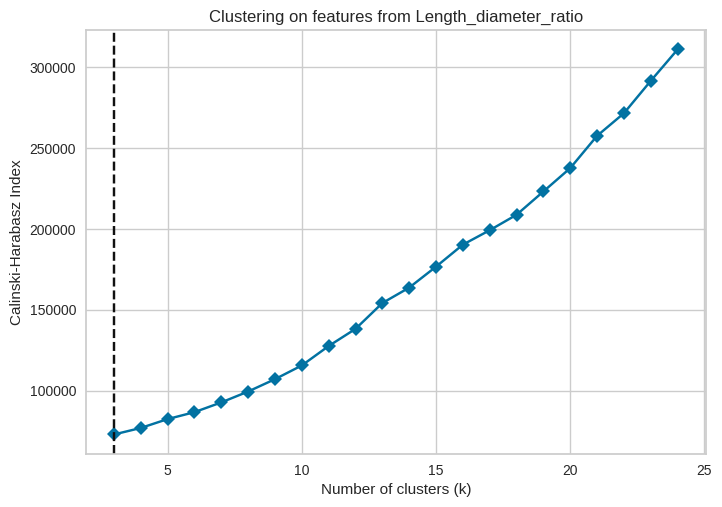

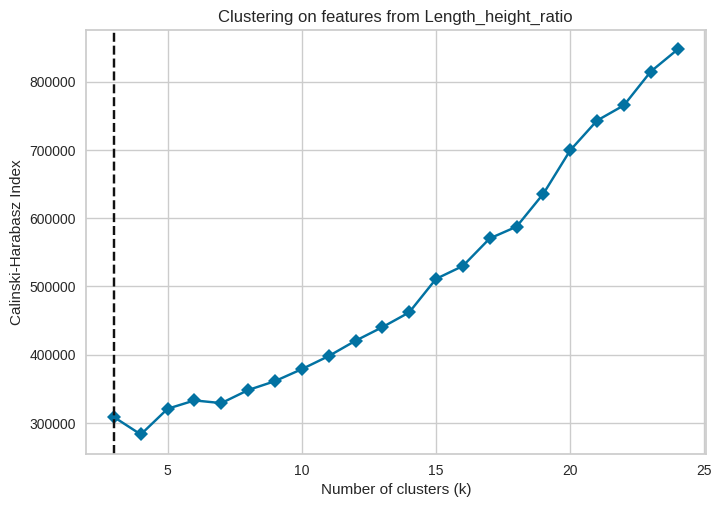

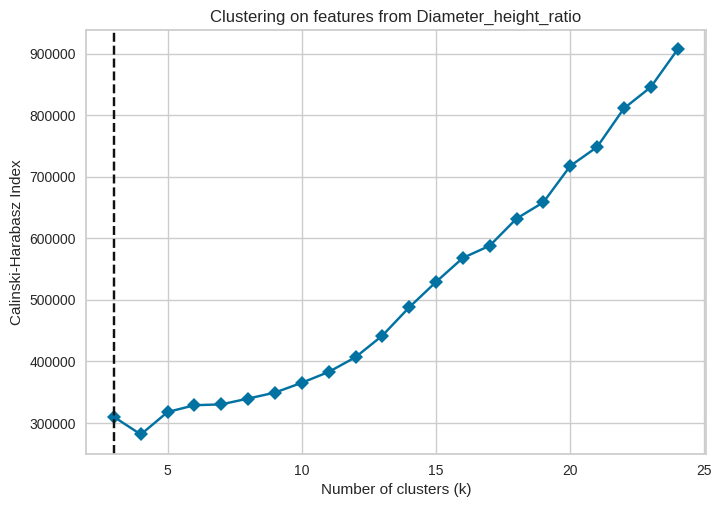

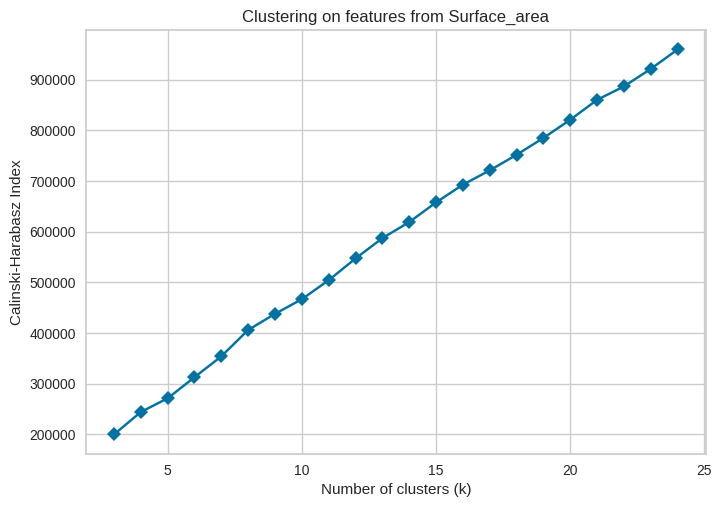

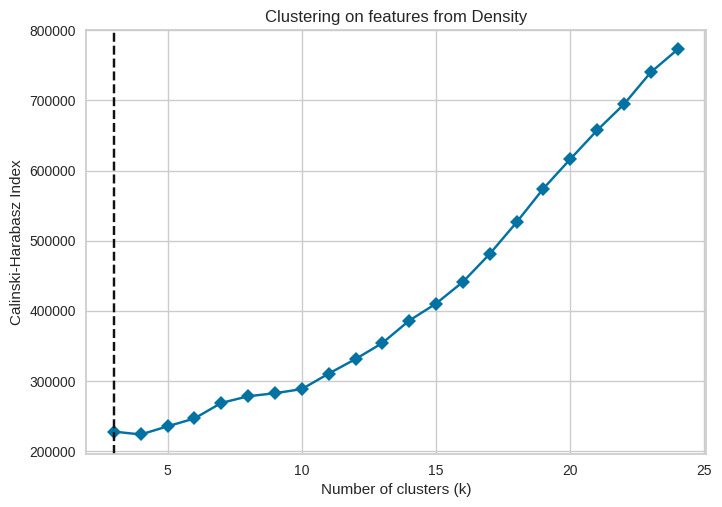

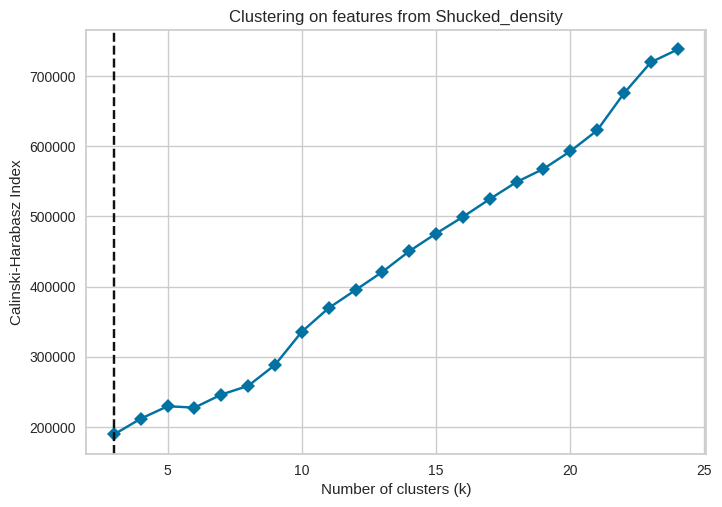

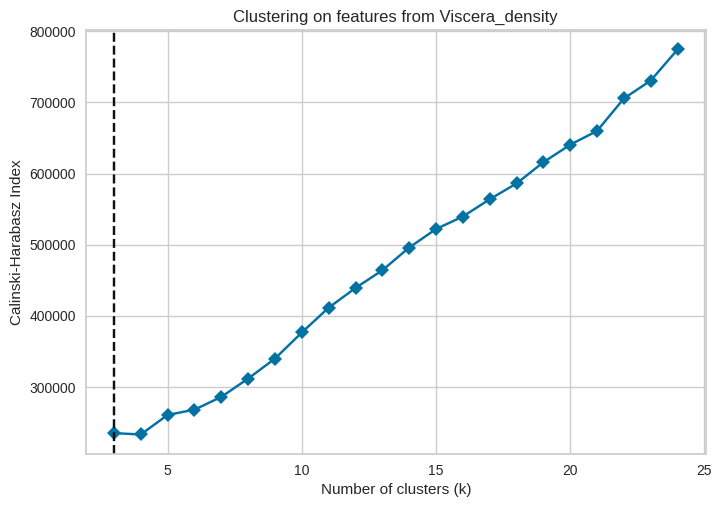

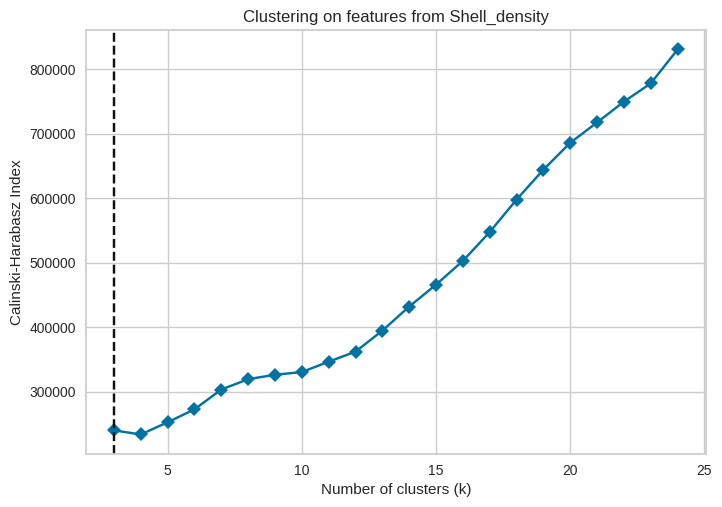

+-----------------------+------------------------------------+----------------------+
|        Original       |     Final Transformed feature      | RMSE(CV)- Regression |
+-----------------------+------------------------------------+----------------------+
|         Length        |           log_pow2Length           |  2.5076538209669175  |
|        Diameter       |          log_pow2Diameter          |  2.487179718732874   |
|         Weight        |         sqrt_Shell Weight          |  2.334147413075595   |
|     Shucked Weight    |        sqrt_Shucked Weight         |  2.6498939151086853  |
|     Viscera Weight    |        sqrt_Viscera Weight         |  2.513522208314093   |
|      Shell Weight     |          y_J_Shell Weight          |  2.3465698582069487  |
|         Volume        |            sqrt_Volume             |  2.453068524874476   |
|      Weight_ratio     |     Weight_ratio_final_cluster     |  3.1362102710044226  |
|  Shucked_weight_ratio |     bx_cx_Shucked_weight_rat

In [19]:
final_drop_list=[]

table = PrettyTable()
table.field_names = ['Original', 'Final Transformed feature', "RMSE(CV)- Regression"]

threshold=0.7
# It is possible that multiple parent features share same child features, so storing selected features to avoid selecting the same feature again
best_cols=[]

for col in cont_cols:
    sub_set=[f for f in train_data.columns if col in f and train_data[f].nunique()>100]
    # print(sub_set)
    
    correlated_features = []

    # Loop through each feature
    for i, feature in enumerate(sub_set):
        # Check correlation with all remaining features
        for j in range(i+1, len(sub_set)):
            correlation = np.abs(train_data[feature].corr(train_data[sub_set[j]]))
            # If correlation is greater than threshold, add to list of highly correlated features
            if correlation > threshold:
                correlated_features.append(sub_set[j])

    if not correlated_features:
        continue
        
    # Remove duplicate features from the list
    correlated_features = list(set(correlated_features))

    temp_train_data=train_data[correlated_features]
    temp_test_data=test_data[correlated_features]
    #Scale before applying PCA
    sc=StandardScaler()
    temp_train_data=sc.fit_transform(temp_train_data)
    temp_test_data=sc.transform(temp_test_data)
    
    # Initiate PCA
    pca=TruncatedSVD(n_components=1)
    x_pca_train_data=pca.fit_transform(temp_train_data)
    x_pca_test_data=pca.transform(temp_test_data)
    x_pca_train_data=pd.DataFrame(x_pca_train_data, columns=[col+"_pca_comb_final"])
    x_pca_test_data=pd.DataFrame(x_pca_test_data, columns=[col+"_pca_comb_final"])
    train_data=pd.concat([train_data,x_pca_train_data],axis='columns')
    test_data=pd.concat([test_data,x_pca_test_data],axis='columns')
    
    # Clustering
    model = KMeans()


    # Initialize the KElbowVisualizer with the KMeans model and desired range of clusters
    visualizer = KElbowVisualizer(model, k=(3, 25), metric='calinski_harabasz', timings=False)

    # Fit the visualizer to the data
    visualizer.fit(np.array(temp_train_data))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Calinski-Harabasz Index')
    plt.title("Clustering on features from "+col)
    plt.show()

    ideal_clusters = visualizer.elbow_value_
    
    if ideal_clusters is None:
        ideal_clusters=3

    # print(ideal_clusters)
    kmeans = KMeans(n_clusters=ideal_clusters)
    kmeans.fit(np.array(temp_train_data))
    labels_train_data = kmeans.labels_

    train_data[col+'_final_cluster'] = labels_train_data
    test_data[col+'_final_cluster'] = kmeans.predict(np.array(temp_test_data))

    cat_labels=np.log1p(train_data.groupby([col+"_final_cluster"])['Age'].mean())
    cat_labels2=cat_labels.to_dict()
    train_data[col+"_final_cluster"]=train_data[col+"_final_cluster"].map(cat_labels2)
    test_data[col+"_final_cluster"]=test_data[col+"_final_cluster"].map(cat_labels2)

    correlated_features=correlated_features+[col+"_pca_comb_final",col+"_final_cluster"]
    
    # See which transformation along with the original is giving you the best univariate fit with target
    kf=KFold(n_splits=5, shuffle=True, random_state=42)
    
    MAE=[]
    
    for f in correlated_features:
        X=train_data[[f]].values
        y=train_data["Age"].values
        
        mae=[]
        for train_data_idx, val_idx in kf.split(X,y):
            X_train_data,y_train_data=X[train_data_idx],y[train_data_idx]
            x_val,y_val=X[val_idx],y[val_idx]
            
            model=LinearRegression()
            model.fit(X_train_data,y_train_data)
            y_pred=model.predict(x_val)
            mae.append(rmse(y_val,y_pred))
        if f not in best_cols:
            MAE.append((f,np.mean(mae)))
    best_col, best_acc=sorted(MAE, key=lambda x:x[1], reverse=False)[0]
    best_cols.append(best_col)
    
    cols_to_drop = [f for f in correlated_features if  f not in best_cols]
    if cols_to_drop:
        final_drop_list=final_drop_list+cols_to_drop
    table.add_row([col,best_col ,best_acc])

print(table)

In [20]:
final_drop_list=[f for f in final_drop_list if f not in cont_cols]
train_data.drop(columns=[*set(final_drop_list)],inplace=True)
test_data.drop(columns=[*set(final_drop_list)],inplace=True)

# Modeling

In [27]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            for random_state in random_state_list:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val

class Regressor:
    def __init__(self, n_estimators=100, device="gpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.reg_models = self._define_reg_model()
        self.len_models = len(self.reg_models)
        
    def _define_reg_model(self):
        
        xgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 6,
            'learning_rate': 0.0116,
            'colsample_bytree': 1,
            'subsample': 0.6085,
            'min_child_weight': 9,
            'reg_lambda': 4.879e-07,
            'max_bin': 431,
            #'booster': 'dart',
            'n_jobs': -1,
            'eval_metric': 'rmse',
            'objective': "reg:squarederror",
            #'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'

        xgb_params2 = {
            'n_estimators': self.n_estimators,
            'max_depth': 7,
            'learning_rate': 0.049,
            'colsample_bytree': 0.5,
            'subsample': 0.7,
            'min_child_weight': 9,
            'reg_lambda': 4.879e-07,
            'max_bin': 431,
            #'booster': 'dart',
            'n_jobs': -1,
            'eval_metric': 'rmse',
            'objective': "reg:squarederror",
            'tree_method': 'approx',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 8,
            "num_leaves": 16,
            'learning_rate': 0.05,
            'subsample': 0.7,
            'colsample_bytree': 0.8,
            #'reg_alpha': 0.25,
            'reg_lambda': 5e-07,
            'objective': 'regression_l2',
            'metric': 'mean_squared_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
        lgb_params2 = {
            'n_estimators': self.n_estimators,
            'max_depth': 10,
            "num_leaves": 16,
            'learning_rate': 0.019000000000000003,
            'subsample': 0.3,
            'colsample_bytree': 0.5,
            'reg_alpha': 0.280490490266035,
            'reg_lambda':0.8609215326333549,
            'objective': 'regression_l2',
            'metric': 'mean_squared_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
        
        cb_params = {
            'iterations': self.n_estimators,
            'depth': 6,
            'learning_rate': 0.02,
            'l2_leaf_reg': 0.5,
            'random_strength': 0.2,
            'max_bin': 150,
            'od_wait': 80,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'IncToDec',
            'eval_metric': 'RMSE',
            'loss_function': 'RMSE',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
        cb_sym_params = cb_params.copy()
        cb_sym_params['grow_policy'] = 'SymmetricTree'
        cb_loss_params = cb_params.copy()
        cb_loss_params['grow_policy'] = 'Lossguide'
    
      
        cb_loss_params={
            'iterations': self.n_estimators,
            'depth': 8,
            'learning_rate': 0.01,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Lossguide',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'RMSE',
            'loss_function': 'RMSE',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
        dt_params= {'min_samples_split': 70, 'min_samples_leaf': 45, 'max_depth': 14, 'criterion': 'squared_error'}
        knn_params= {'weights': 'uniform', 'p': 1, 'n_neighbors': 12, 'leaf_size': 20, 'algorithm': 'kd_tree'}

        reg_models = {
            'xgb_reg': xgb.XGBRegressor(**xgb_params),
            'xgb_reg2': xgb.XGBRegressor(**xgb_params2),

#             'lgb_reg2': lgb.LGBMRegressor(**lgb_params),
            'lgb_reg': lgb.LGBMRegressor(**lgb_params2),
            "hgbm": HistGradientBoostingRegressor(max_iter=self.n_estimators, learning_rate=0.05, loss="squared_error", 
                                                  n_iter_no_change=400,random_state=self.random_state),
            'cat_reg': CatBoostRegressor(**cb_params),
            "cat_sym": CatBoostRegressor(**cb_sym_params),
            "cat_loss": CatBoostRegressor(**cb_loss_params),
            'etr': ExtraTreesRegressor(min_samples_split=20, min_samples_leaf= 15, max_depth=10,
                                       n_estimators=200,random_state=self.random_state),
            "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=500,max_depth= 5, learning_rate= 0.127,loss="squared_error", random_state=self.random_state),
            "RandomForestRegressor": RandomForestRegressor(max_depth= 6,max_features= 'auto',min_samples_split= 4,
                                                           min_samples_leaf= 4,  n_estimators=500, random_state=self.random_state, n_jobs=-1),
            'dt': DecisionTreeRegressor(**dt_params),
            
#             "lr":LinearRegression(),
#             "knn":KNeighborsRegressor(**knn_params),
#             "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=3000, tol=1e-3, n_iter_no_change=30, random_state=self.random_state),
#             "HuberRegressor": HuberRegressor(max_iter=3000),
            
        }


        return reg_models

In [28]:
class OptunaWeights:
    def __init__(self, random_state):
        self.study = None
        self.weights = None
        self.random_state = random_state

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the MAE score for the weighted prediction
        score = rmse(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds, n_trials=300):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        self.study = optuna.create_study(sampler=sampler, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds, n_trials=300):
        self.fit(y_true, y_preds, n_trials=n_trials)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [25]:
X_train=train_data.drop(['Age'],axis=1)
y_train=train_data['Age']

X_test=test_data.copy()

print(X_train.shape,X_test.shape)

(74051, 151) (49368, 151)


In [45]:
kfold = True
n_splits = 1 if not kfold else 10
random_state = 42
random_state_list = [42] 
n_estimators = 9999 
early_stopping_rounds = 200
verbose = False
device = 'cpu'

splitter = Splitter(kfold=kfold, n_splits=n_splits)


# Initialize an array for storing test predictions
test_predss = np.zeros(X_test.shape[0])
ensemble_score = []
weights = []
trained_models = dict(zip(Regressor().reg_models.keys(), [[] for _ in range(Regressor().len_models)]))
trained_models = {'lgb_reg':[], 'cat_reg':[],'xgb_reg':[]}

# Evaluate on validation data and store predictions on test data
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits

    # Get a set of Regressor models
    reg = Regressor(n_estimators, device, random_state)
    models = reg.reg_models

    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []

    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if ('cat' in name) or ("lgb" in name) or ("xgb" in name):
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        elif name=='hgbm':
            model.fit(X_train_, y_train_)
        elif name=='ann':
            model.fit(X_train_, y_train_, validation_data=(X_val, y_val),batch_size=2, epochs=60,verbose=verbose)
        else:
            model.fit(X_train_, y_train_)
        if name=="ann":
            y_val_pred = model.predict(X_val)[:,0]
            test_pred = model.predict(X_test)[:,0]
        else:
            y_val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)


        score = rmse(y_val, y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] RMSE score: {score:.5f}')

        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))

    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    score = rmse(y_val, y_val_pred)
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] RMSE score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))

    gc.collect()

xgb_reg [FOLD-0 SEED-42] RMSE score: 2.04315
xgb_reg2 [FOLD-0 SEED-42] RMSE score: 2.04810
lgb_reg [FOLD-0 SEED-42] RMSE score: 2.04353
hgbm [FOLD-0 SEED-42] RMSE score: 2.05508
cat_reg [FOLD-0 SEED-42] RMSE score: 2.04846
cat_sym [FOLD-0 SEED-42] RMSE score: 2.04503
cat_loss [FOLD-0 SEED-42] RMSE score: 2.04614
etr [FOLD-0 SEED-42] RMSE score: 2.06536
GradientBoostingRegressor [FOLD-0 SEED-42] RMSE score: 2.07817
RandomForestRegressor [FOLD-0 SEED-42] RMSE score: 2.08334
dt [FOLD-0 SEED-42] RMSE score: 2.13871
Ensemble [FOLD-0 SEED-42] RMSE score 2.04083


NameError: name 'gc' is not defined

In [49]:
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble RMSE score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name} {mean_weight:.5f} ± {std_weight:.5f}')

Ensemble RMSE score 2.04083 ± 0.00000
--- Model Weights ---
xgb_reg 0.78039 ± 0.00000
xgb_reg2 0.88668 ± 0.00000
lgb_reg 0.84808 ± 0.00000
hgbm 0.15834 ± 0.00000
cat_reg 0.01624 ± 0.00000
cat_sym 0.80827 ± 0.00000
cat_loss 0.03113 ± 0.00000
etr 0.03638 ± 0.00000
GradientBoostingRegressor 0.03662 ± 0.00000
RandomForestRegressor 0.03679 ± 0.00000
dt 0.07422 ± 0.00000


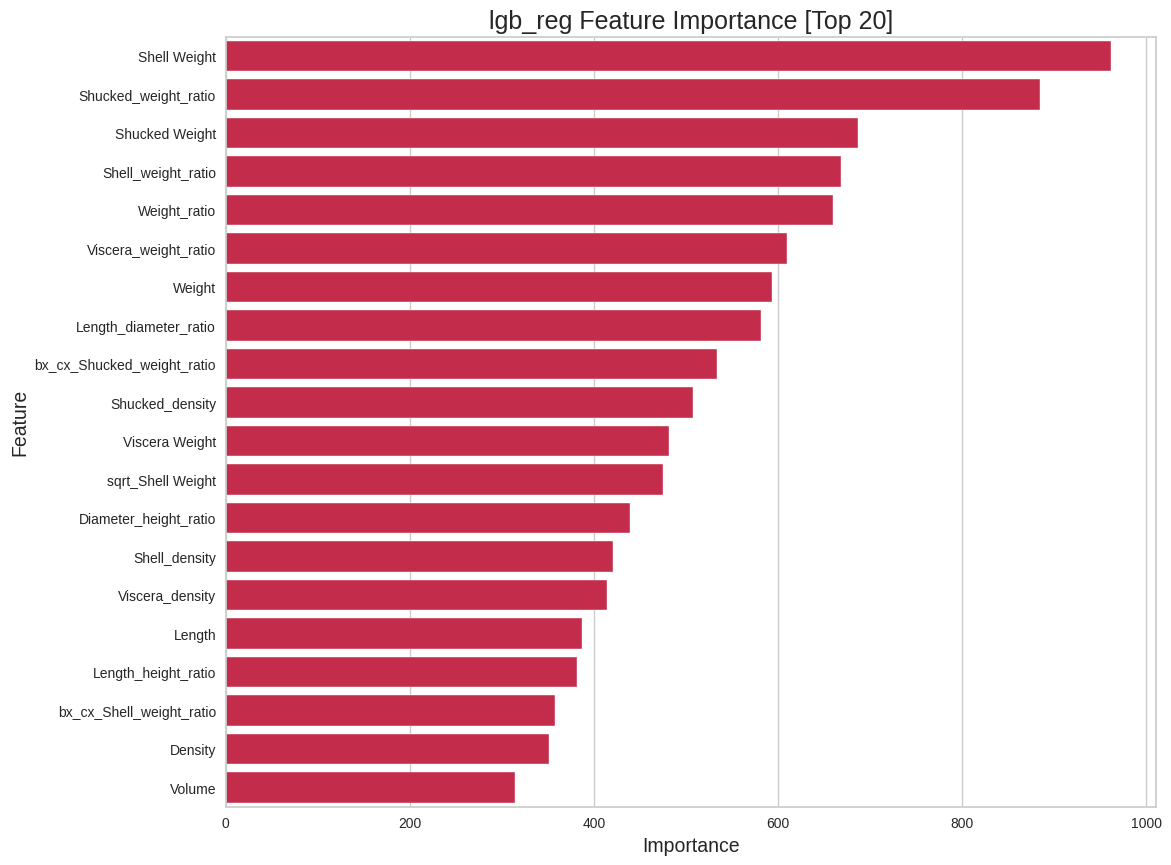

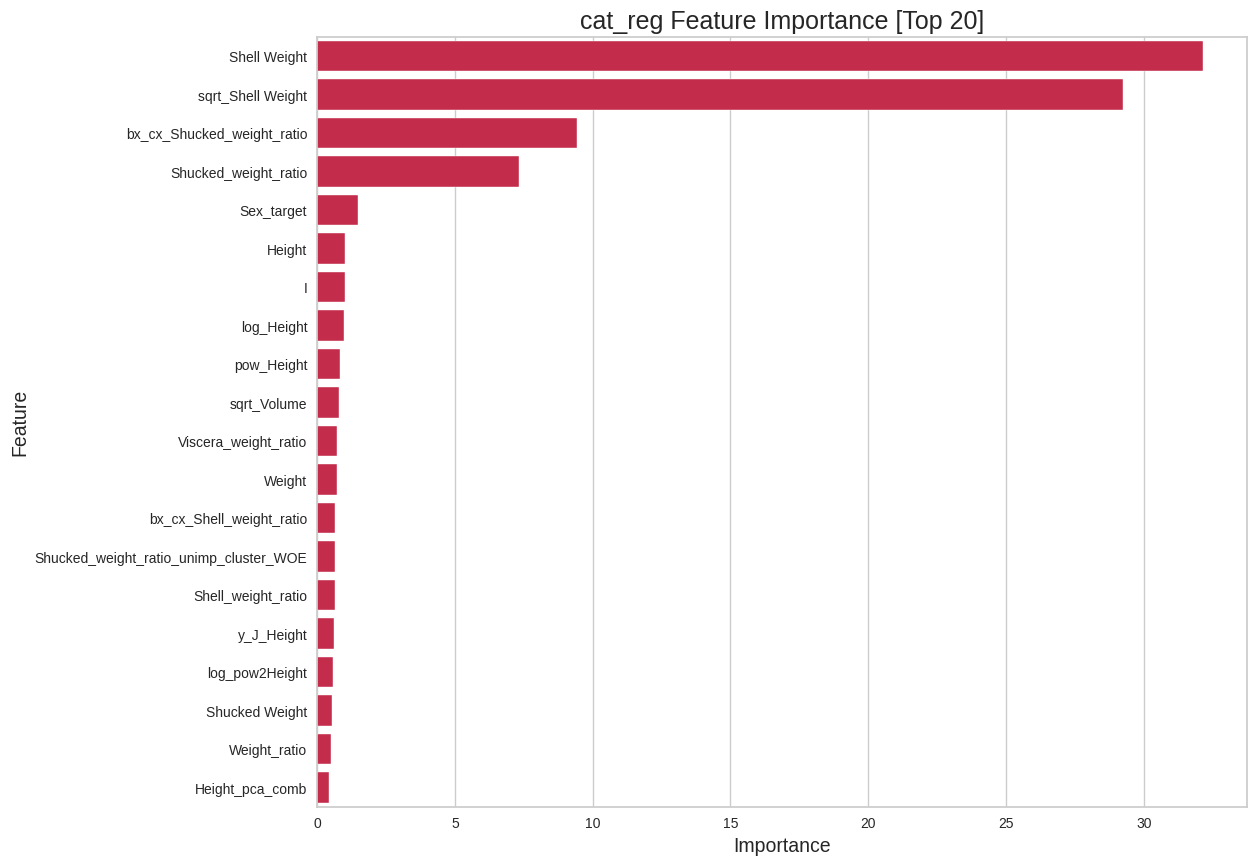

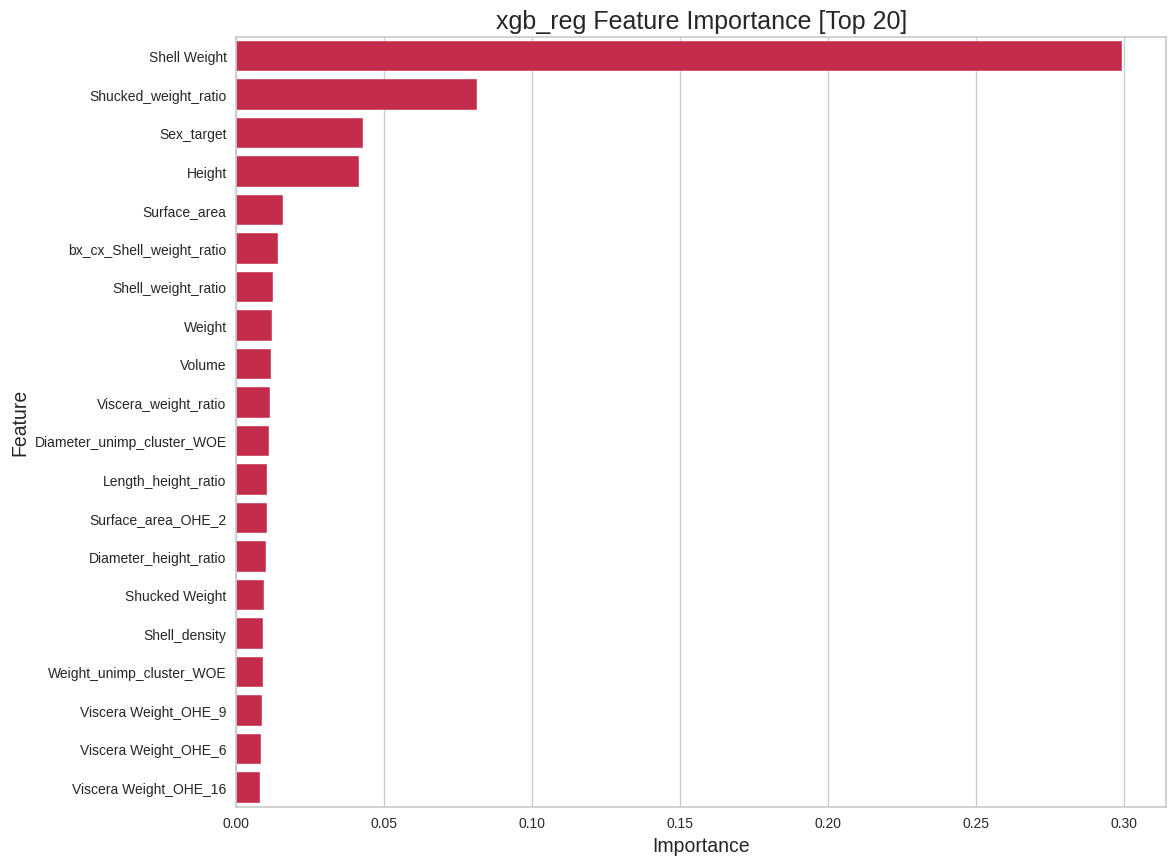

In [50]:
def visualize_importance(models, feature_cols, title, top=20):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["importance"] = model.feature_importances_
        _df["feature"] = pd.Series(feature_cols)
        _df["fold"] = i
        _df = _df.sort_values('importance', ascending=False)
        _df = _df.head(top)
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)
        
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis=1))
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance, color='crimson', errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance [Top {top}]', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()
    
for name, models in trained_models.items():
    visualize_importance(models, list(X_train.columns), name)

In [62]:
from  statistics import mean
mean(test_predss)

0.9991578461091721

In [55]:
len(test_predss)

49368

In [51]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e16/sample_submission.csv')
sub['Age'] = test_predss
sub.to_csv('submission.csv',index=False)
sub

,id,Age
0,74051,0.762816
1,74052,0.775214
2,74053,1.065419
3,74054,0.961163
4,74055,0.743539
...,...,...
49363,123414,0.945788
49364,123415,0.798561
49365,123416,1.326003
49366,123417,1.021711


In [1]:
import pandas as pd

In [3]:
test_data = pd.read_csv('data/test.csv')

In [6]:
for index, i in enumerate(range(0, len(test_data), 5000)):
    test_data.iloc[i:i+5000].to_csv(f'data/test_{index}.csv')

In [7]:
len(pd.read_csv('data/test_9.csv'))

4368